In [1]:
## basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## statistics
from scipy.stats import zscore
from scipy.stats import ttest_rel ## paired t-test
from scipy.stats import ttest_ind ## two-sample t-test


## system
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

##
import PyComplexHeatmap as pyc
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

## Define Helper Functions

In [2]:
def scale(df,
          method="standard"):
    
    if method == "standard":
        scaler = StandardScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df),
                                 index = df.index,
                                 columns = df.columns)
        return df_scaled

    if method == "double_z":
        df_scaled = df.apply(zscore,axis=1).\
            apply(zscore, axis=0)

    else:
        df_scaled = df

    return df_scaled

def umap_wrapper(df,
                 df_meta=None,
                 n_pca=10,
                 remove_PC1=True,
                 n_neighbors=15,
                 n_umap=3,
                 learning_rate=1,
                 min_dist=0.1,
                 spread = 1,
                 metric="euclidean",
                 random_state=42):

    assert min_dist <= spread

    print(f"Input data dimension: {df.shape}")

    if df_meta is not None:
        print(f"Input meta-data dimension: {df_meta.shape}")
    else:
        print("No meta-info")
    
    ## perform linear PCA
    pca = PCA(n_components=n_pca)
    df_pca = pd.DataFrame(pca.fit_transform(df),
                          columns = ["PC" + str(i) for i in range(1, n_pca+1)],
                          index = df.index)

    ## UMAP
    umap_embedding = umap.UMAP(n_neighbors=n_neighbors,
                               n_components=n_umap, 
                               learning_rate=learning_rate,
                               min_dist=min_dist,
                               spread = spread,
                               metric=metric,
                               random_state=random_state)
    ## remove "PC1"
    if remove_PC1:
        df_umap = pd.DataFrame(umap_embedding.fit_transform(df_pca.drop("PC1",axis=1)),
                           columns = ["UMAP" + str(i) for i in range(1, n_umap+1)],
                           index = df_pca.index)
    
        print(f"Dimension after UMAP: {df_umap.shape}")
    else:
        df_umap = pd.DataFrame(umap_embedding.fit_transform(df_pca),
                           columns = ["UMAP" + str(i) for i in range(1, n_umap+1)],
                           index = df_pca.index)

    if df_meta is not None:
        ## merge meta-data
        df_umap = pd.merge(df_meta, df_umap, left_index=True, right_index=True)
        df_pca = pd.merge(df_meta, df_pca, left_index=True, right_index=True)
    
        print(f"Dimension after merging: {df_umap.shape}")

    return df_umap, df_pca

def age_binned(age):
    
    if age <= 45:
        return "age < 45"
    if 45 < age <= 55:
        return " 45 < age <= 55"
    if 55 < age <= 65:
         return " 55 < age <= 65"
    if 65 < age <= 75:
         return " 65 < age <= 75"
    
    if 75 < age <= 85:
         return " 75 < age <= 85"

    return "> 85"

## Load Data

In [3]:
with open('/screening/notebooks/zhuang/summer_2024/data/region_ids.pkl', 'rb') as f:
        region_ids = pickle.load(f)

with open('/screening/notebooks/zhuang/summer_2024/data/df_ldt.pkl', 'rb') as f:
        df_ldt = pickle.load(f)

## Query region meta-data to obtain "positive_control" regions
v6_region = "/screening/data/methylation/sandbox_pipeline/assets/mafband_v2023_12_23/msre_regions.tsv"
pos_control = pd.read_csv(v6_region, sep="\t").\
    query('merged_region_type == "HYPER_CONTROL"').\
    loc[:,"region_id"].\
    reset_index(drop=True)
pos_control_in_s3 = [i for i in pos_control if i in region_ids]

print(f"There are {len(pos_control_in_s3)} positive control regions in S3")

## Prediction from Lung Model: MB_S3_V4
called_samples = pd.read_csv("../data/called_discovery_lung_samples.tsv",sep="\t").\
    assign(called = lambda df: np.where(df['sample_group'] == "cancer_free", "FP", "TP"))

not_called_samples = pd.read_csv("../data/not_called_discovery_lung_samples.tsv", sep="\t").\
    assign(called = lambda df: np.where(df['sample_group'] == "cancer_free", "TN", "FN"))

lung_MB_S3_V4 =  pd.concat([called_samples, not_called_samples],axis=0).\
    loc[:,["unique_sample_id","called"]].\
    set_index("unique_sample_id")

df_lung = df_ldt.loc[:,["unique_sample_id","sample_group","age","sex","histological_subtype", 'g360_max_maf_pct', 'tvf_max_maf_pct']+region_ids].\
    query('sample_group == "lung"').\
    set_index("unique_sample_id").\
    drop(pos_control_in_s3,axis=1).\
    assign(histological_subtype = lambda df: np.where(df['histological_subtype'].isin(['adenocarcinoma', 'squamous_cell_carcinoma']), df['histological_subtype'], "unknown"),
          log_g360_maf = lambda df: np.log(df['g360_max_maf_pct']),
          log_tvf_maf =  lambda df: np.log(df['tvf_max_maf_pct']))

df_lung = pd.merge(df_lung, lung_MB_S3_V4, left_index = True, right_index = True, how = "left")

## drop regions whose values are -5 across all samples
no_molecule = [col for col in df_lung.columns if (df_lung[col]==-5).all()]
print(f"There are {len(no_molecule)} regions with no molecules")
df_lung = df_lung.drop(no_molecule,axis=1)

print(f"Lung data dimension: {df_lung.shape}")

There are 41 positive control regions in S3
There are 5477 regions with no molecules
Lung data dimension: (996, 21833)


## Load Region Data

In [4]:
## p80-p100
## drop NaN
## inf = high ~ 10
## sens_threshold = 50
## lod = -1 = bad

#top = 5000
snr = pd.read_csv(os.getcwd()+"/../data/snrs.tsv",sep="\t").\
    query('sample_group == "lung"').\
    replace(np.inf, 40).\
    sort_values("snr_p100",ascending=False).\
    set_index("region_id")
    

LoD = pd.read_csv(os.getcwd()+"/../data/tvf_max_maf_pct_90_lods.tsv",sep="\t").\
    query('sample_group_cancer == "lung" and lod != -1 and sens_threshold==50 and lod <= 1').\
    set_index("region_id").\
    assign(log_lod = lambda df: np.log(df['lod']))

region_anno = pd.merge(LoD, snr, left_index=True, right_index=True, how="left")

## V6
v6_regions = pd.read_csv(v6_region, sep="\t").\
    query('merged_region_type != "HYPER_CONTROL"').\
    assign(panel = "V6").\
    loc[:,["region_id","panel"]].\
    set_index("region_id")

## region annotation
region_anno["in_v6"] = ["yes" if i in v6_regions.index else "no" for i in region_anno.index]

## check coverage
region_anno["no_molecule"] = ["yes" if i in no_molecule else "no" for i in region_anno.index]

## regions of interest
regions_of_interest = list(region_anno.index)

print(f"There are {len(regions_of_interest)} regions of interest")

There are 1028 regions of interest


In [5]:
region_anno.head()

sens_threshold    lod          maf_arg sample_group_cancer  \
region_id                                                                 
merged_1063              50  0.933  tvf_max_maf_pct                lung   
merged_1084              50  0.879  tvf_max_maf_pct                lung   
merged_1114              50  0.953  tvf_max_maf_pct                lung   
merged_1120              50  0.696  tvf_max_maf_pct                lung   
merged_1145              50  0.957  tvf_max_maf_pct                lung   

              log_lod sample_group   snr_p15   snr_p30   snr_p50   snr_p80  \
region_id                                                                    
merged_1063 -0.069350         lung  0.021951  0.088778  0.144192  0.203556   
merged_1084 -0.128970         lung  1.566865  1.790218  2.024377  2.172759   
merged_1114 -0.048140         lung  1.298919  1.611533  1.798833  1.902381   
merged_1120 -0.362406         lung  2.456439  2.873650  3.254021  3.236376   
merged_1145 -0.043952         lung  1.679814  2.347190  2.919942  3.302863   

              snr_p90   snr_p98  snr_p100 in_v6 no_molecule  
region_id                                                    
merged_1063  0.220116  0.232560  0.235573   yes          no  
merged_1084  2.208378  2.214453  2.234390   yes          no  
merged_1114  1.930828  1.951325  1.969295   yes          no  
merged_1120  3.221483  3.185637  3.199183   yes          no  
merged_1145  3.244055  3.181707  3.217006   yes          no

## More information

In [6]:
tvf2 = pd.read_csv("../data/tfv2gamma.tsv",sep="\t").\
    rename(columns={"value":"tumor_fraction"})

## for Cancer-free vs. CRC
mb = pd.read_csv("../data/merged.msre_mr_call.hdr.tsv",sep="\t")

tvf2_mb = pd.merge(tvf2, mb, on = ["runid","run_sample_id"], how="inner").\
    set_index("unique_sample_id").\
    drop(["runid", "run_sample_id", "norm_flavor", "metric", "hyper_residual_count_pos_ctrl", "model_name"], axis=1)


## merge to cancer-free samples
df_lung = pd.merge(df_lung, tvf2_mb, how="left", left_index=True, right_index=True).\
    assign(log_tumor_fraction = lambda df: np.log(df["tumor_fraction"]))

## missing sample = 33

## Preprocess Data

In [7]:
pdata_lung = ["sample_group","age","sex", "histological_subtype", "g360_max_maf_pct", "tvf_max_maf_pct", "log_g360_maf", "log_tvf_maf", "called","tumor_fraction", "log_tumor_fraction", "methyl_score", "threshold", "methyl_call"]

## meta-data
df_lung_meta = df_lung.loc[:,pdata_lung]


## region score and scaling
df_lung_region = df_lung.drop(pdata_lung,axis=1)

df_lung_standard = scale(df_lung_region,
                         method = "standard")

print(df_lung_standard.shape)

df_lung_double_z = scale(df_lung_region,
                         method = "double_z")

print(df_lung_double_z.shape)

## subset regions to regions_of_interest
cols = [col for col in df_lung_standard.columns if col in regions_of_interest]
print(f"There are {len(cols)} regions of interest")

df_lung_standard_roi = df_lung_standard[cols]
df_lung_double_z_roi = df_lung_double_z[cols]

(996, 21824)
(996, 21824)
There are 1003 regions of interest


### Median region score/standard scaling/double-z scores of each region

In [8]:
region_anno_all = pd.DataFrame().\
    assign(region_score_median = df_lung_region.apply(lambda x: np.median(x)),
           standard_median = df_lung_standard.apply(lambda x: np.median(x)),
           double_z_median = df_lung_double_z.apply(lambda x: np.median(x)),
           pos_control = lambda df: np.where(df.index.isin(pos_control_in_s3),1,0))
           

region_anno_all.head()

region_score_median  standard_median  double_z_median  \
s3_region_1                 -5.0        -0.173204        -0.130698   
s3_region_2                 -5.0        -0.287269        -0.203264   
s3_region_3                 -5.0        -0.069808         0.042931   
s3_region_4                 -5.0        -0.148563        -0.066986   
s3_region_5                 -5.0        -0.059923         0.035229   

             pos_control  
s3_region_1            0  
s3_region_2            0  
s3_region_3            0  
s3_region_4            0  
s3_region_5            0

In [9]:
## Add these information to "regions of interest"
region_anno = pd.merge(region_anno, region_anno_all, how="left", left_index=True, right_index=True)

region_anno.head()

sens_threshold    lod          maf_arg sample_group_cancer  \
region_id                                                                 
merged_1063              50  0.933  tvf_max_maf_pct                lung   
merged_1084              50  0.879  tvf_max_maf_pct                lung   
merged_1114              50  0.953  tvf_max_maf_pct                lung   
merged_1120              50  0.696  tvf_max_maf_pct                lung   
merged_1145              50  0.957  tvf_max_maf_pct                lung   

              log_lod sample_group   snr_p15   snr_p30   snr_p50   snr_p80  \
region_id                                                                    
merged_1063 -0.069350         lung  0.021951  0.088778  0.144192  0.203556   
merged_1084 -0.128970         lung  1.566865  1.790218  2.024377  2.172759   
merged_1114 -0.048140         lung  1.298919  1.611533  1.798833  1.902381   
merged_1120 -0.362406         lung  2.456439  2.873650  3.254021  3.236376   
merged_1145 -0.043952         lung  1.679814  2.347190  2.919942  3.302863   

              snr_p90   snr_p98  snr_p100 in_v6 no_molecule  \
region_id                                                     
merged_1063  0.220116  0.232560  0.235573   yes          no   
merged_1084  2.208378  2.214453  2.234390   yes          no   
merged_1114  1.930828  1.951325  1.969295   yes          no   
merged_1120  3.221483  3.185637  3.199183   yes          no   
merged_1145  3.244055  3.181707  3.217006   yes          no   

             region_score_median  standard_median  double_z_median  \
region_id                                                            
merged_1063            -5.000000        -0.102909         0.011259   
merged_1084            -4.455528        -0.288598         0.001649   
merged_1114            -4.429724        -0.276919         0.007534   
merged_1120            -4.236945        -0.177630         0.126809   
merged_1145            -5.000000        -0.683559        -0.644936   

             pos_control  
region_id                 
merged_1063          0.0  
merged_1084          0.0  
merged_1114          0.0  
merged_1120          0.0  
merged_1145          0.0

## Linear PCA Explained Variance Ratio and Correlation with MAF

In [10]:
def pca_wrapper(df,
                maf=None,
                n=10):
    pca = PCA(n_components=n)
    
    df_pca = pd.DataFrame(pca.fit_transform(df),
                      index = df.index)    

    if maf:
        df_pca['maf'] = maf
    
        print(df_pca.columns[-1])
    
        maf_corr = df_pca.dropna().\
        iloc[:,:-1].\
        apply(lambda x: x.corr(df.iloc[:,-1]))
    
        var_ratio = pca.explained_variance_ratio_


        return var_ratio, maf_corr
    else:
        return pca.explained_variance_ratio_

### Sample

maf
maf
maf
maf


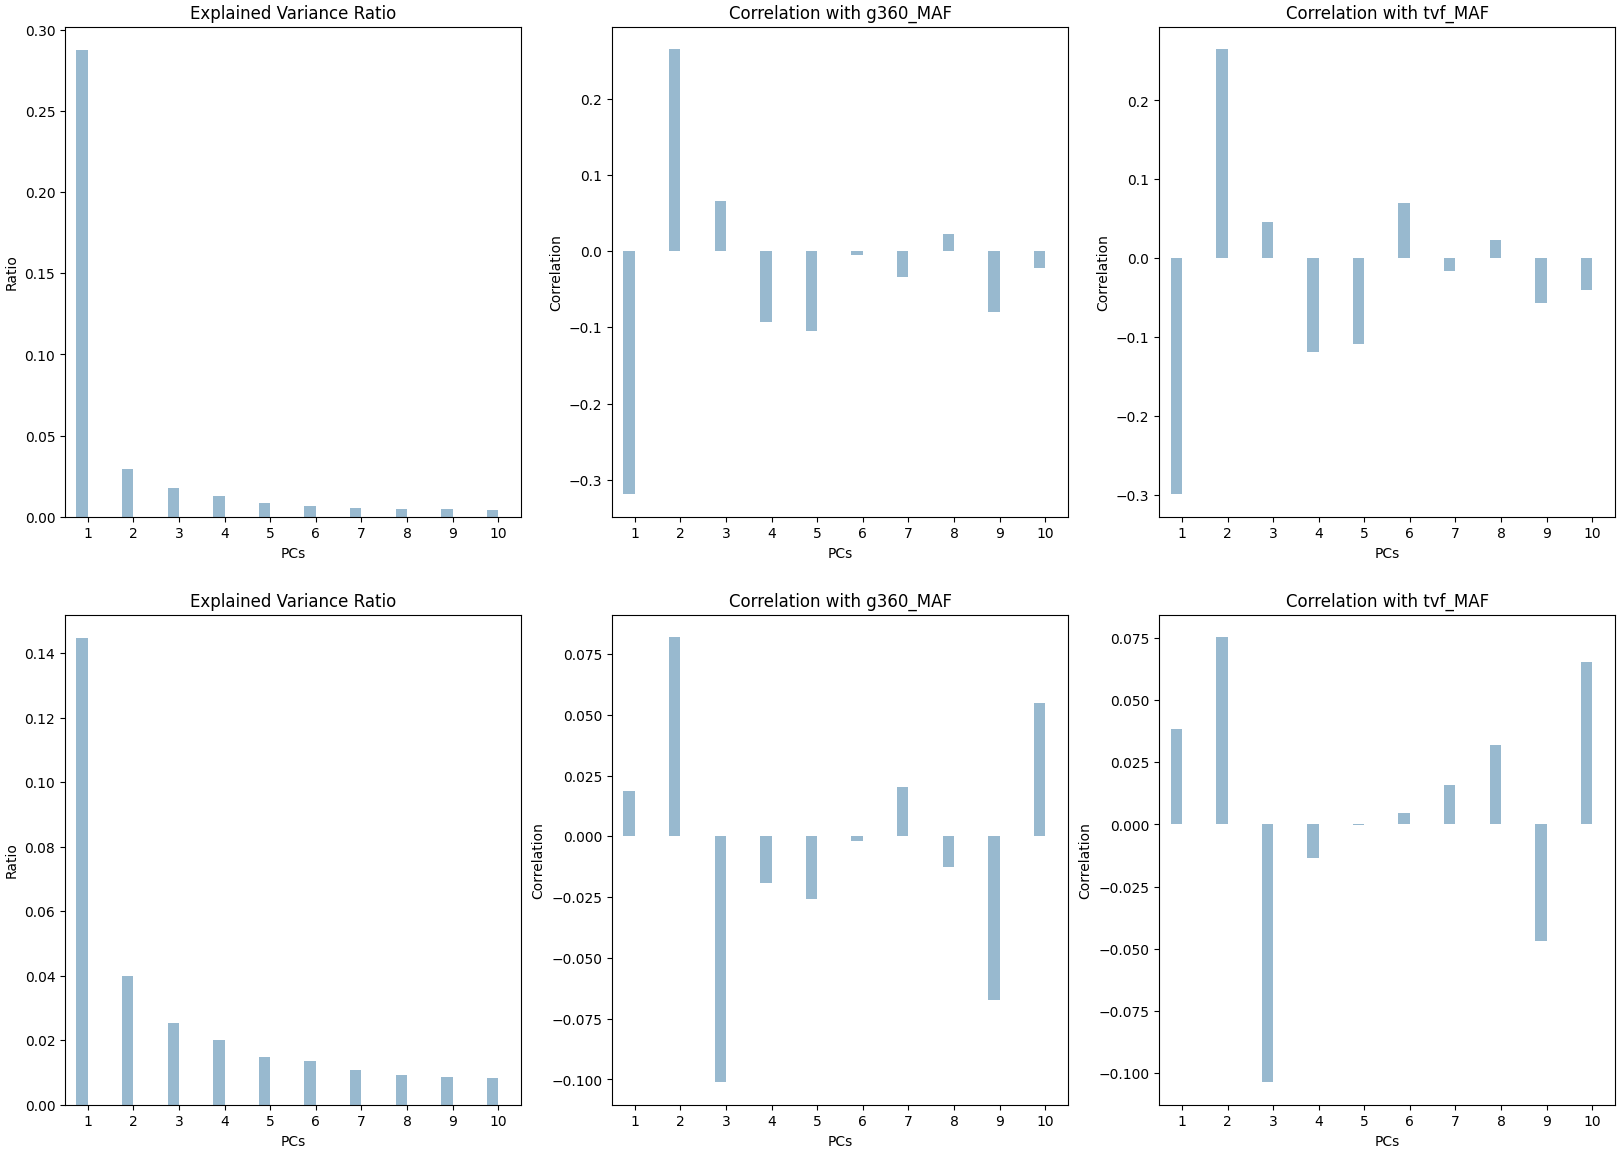

In [11]:
n = 10

var_ratio_lung_z, g360_maf_corr_lung_z = pca_wrapper(df_lung_double_z.drop([i for i in pos_control_in_s3 if i in df_lung_double_z.columns],axis=1),
                                                     maf = list(df_lung_meta['g360_max_maf_pct']),
                                                     n = n)


var_ratio_lung_standard, g360_maf_corr_lung_standard = pca_wrapper(df_lung_standard.drop([i for i in pos_control_in_s3 if i in df_lung_standard.columns],axis=1),
                                                                   maf = list(df_lung_meta['g360_max_maf_pct']),
                                                                   n = n)

_, tvf_maf_corr_lung_z = pca_wrapper(df_lung_double_z.drop([i for i in pos_control_in_s3 if i in df_lung_double_z.columns],axis=1),
                                     maf = list(df_lung_meta['tvf_max_maf_pct']),
                                     n = n)

_, tvf_maf_corr_lung_standard = pca_wrapper(df_lung_standard.drop([i for i in pos_control_in_s3 if i in df_lung_standard.columns],axis=1),
                                            maf = list(df_lung_meta['tvf_max_maf_pct']),
                                            n = n)


fig, axes = plt.subplots(2,3,figsize=(20,14))

with plt.style.context('_classic_test_patch'):

        ## first row = double-z
        sns.barplot(x = list(range(1, n+1)),
                    y = var_ratio_lung_z,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[0,0])
    
        axes[0,0].set_title("Explained Variance Ratio", fontsize=12)
        axes[0,0].set_xlabel("PCs", fontsize=10)
        axes[0,0].set_ylabel("Ratio", fontsize=10)

    
        sns.barplot(x = list(range(1, n+1)),
                    y = g360_maf_corr_lung_z,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[0,1])
    
        axes[0,1].set_title("Correlation with g360_MAF", fontsize=12)
        axes[0,1].set_xlabel("PCs", fontsize=10)
        axes[0,1].set_ylabel("Correlation", fontsize=10)

        sns.barplot(x = list(range(1, n+1)),
                    y = tvf_maf_corr_lung_z,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[0,2])
    
        axes[0,2].set_title("Correlation with tvf_MAF", fontsize=12)
        axes[0,2].set_xlabel("PCs", fontsize=10)
        axes[0,2].set_ylabel("Correlation", fontsize=10)

        
    
        ## second row = standard
        sns.barplot(x = list(range(1, n+1)),
                    y = var_ratio_lung_standard,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[1,0])
    
        axes[1,0].set_title("Explained Variance Ratio", fontsize=12)
        axes[1,0].set_xlabel("PCs", fontsize=10)
        axes[1,0].set_ylabel("Ratio", fontsize=10)

    
        sns.barplot(x = list(range(1, n+1)),
                    width = 0.25,
                    y = g360_maf_corr_lung_standard,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[1,1])
    
        axes[1,1].set_title("Correlation with g360_MAF", fontsize=12)
        axes[1,1].set_xlabel("PCs", fontsize=10)
        axes[1,1].set_ylabel("Correlation", fontsize=10)

        sns.barplot(x = list(range(1, n+1)),
                    width = 0.25,
                    y = tvf_maf_corr_lung_standard,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[1,2])

        axes[1,2].set_title("Correlation with tvf_MAF", fontsize=12)
        axes[1,2].set_xlabel("PCs", fontsize=10)
        axes[1,2].set_ylabel("Correlation", fontsize=10)

### Regions

In [12]:
def pca_wrapper_region(df_region,
                       n=10):
    
    pca = PCA(n_components=n)
    
    df_pca = pd.DataFrame(pca.fit_transform(df_region),
                          index = df_region.index,
                          columns = ["PC" + str(i) for i in range(1, n+1)] )    
    
    var_ratio = pca.explained_variance_ratio_


     
    return df_pca, var_ratio

#### All regions

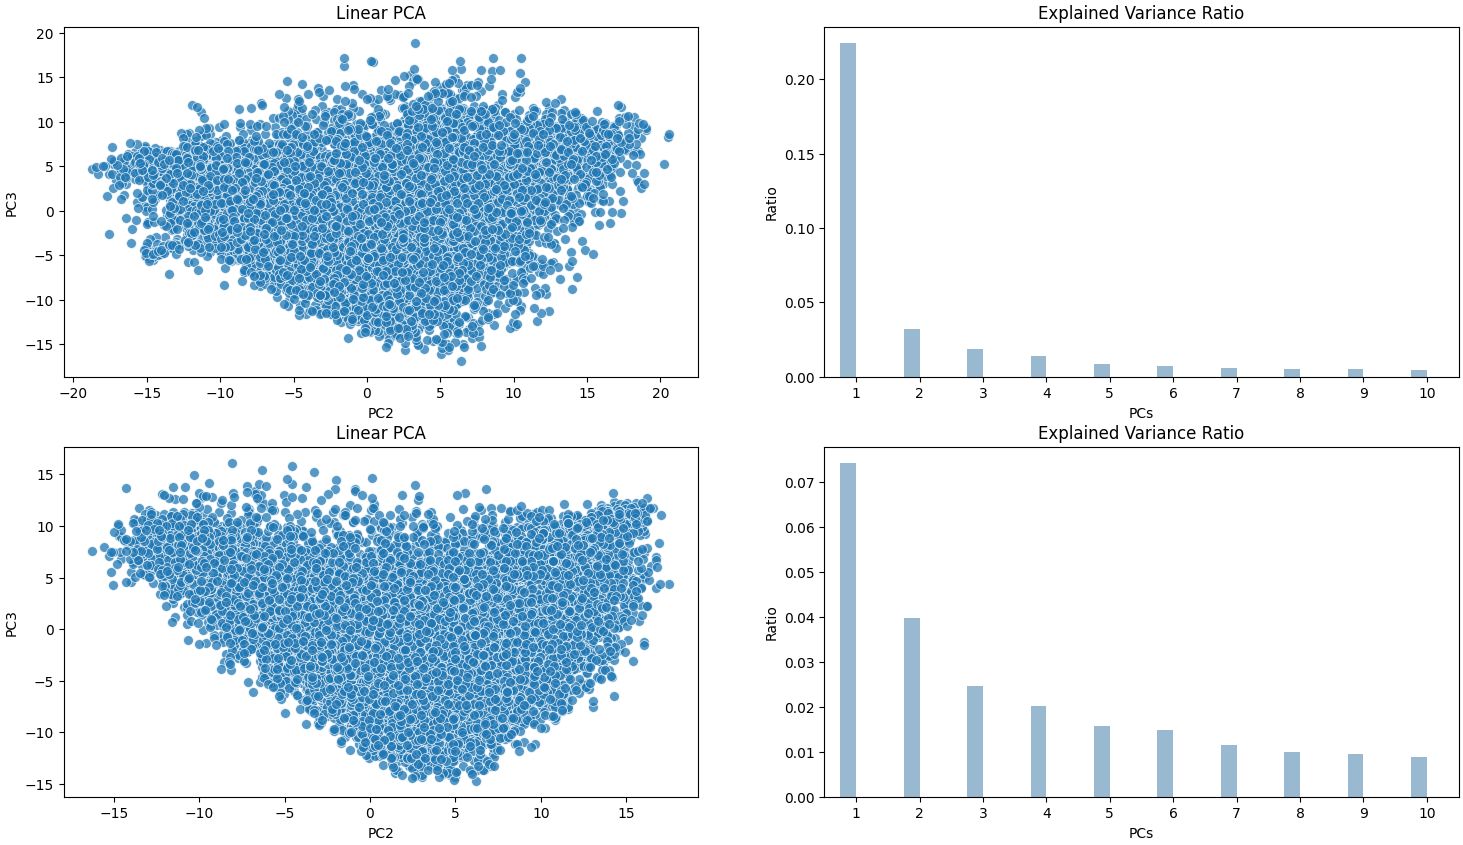

In [13]:
n = 10

df_pca_z, var_ratio_z = pca_wrapper_region(df_lung_double_z.T,
                                            n = n)

df_pca_standard, var_ratio_standard = pca_wrapper_region(df_lung_standard.T,
                                                          n = n)

fig, axes = plt.subplots(2,2, figsize=(18,10))

with plt.style.context('_classic_test_patch'):

    
    ## first row = double-z
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    data = df_pca_z,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[0,0])

    axes[0,0].set_title("Linear PCA", fontsize=12)
    axes[0,0].set_xlabel("PC2", fontsize=10)
    axes[0,0].set_ylabel("PC3", fontsize=10)
    
    
    sns.barplot(x = list(range(1, n+1)),
                    y = var_ratio_z,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[0,1])
    
    axes[0,1].set_title("Explained Variance Ratio", fontsize=12)
    axes[0,1].set_xlabel("PCs", fontsize=10)
    axes[0,1].set_ylabel("Ratio", fontsize=10)

    ## second row = standard
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    data = df_pca_standard,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[1,0])

    axes[1,0].set_title("Linear PCA", fontsize=12)
    axes[1,0].set_xlabel("PC2", fontsize=10)
    axes[1,0].set_ylabel("PC3", fontsize=10)
    
    
    sns.barplot(x = list(range(1, n+1)),
                    y = var_ratio_standard,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[1,1])
    
    axes[1,1].set_title("Explained Variance Ratio", fontsize=12)
    axes[1,1].set_xlabel("PCs", fontsize=10)
    axes[1,1].set_ylabel("Ratio", fontsize=10)

#### Regions of Interest

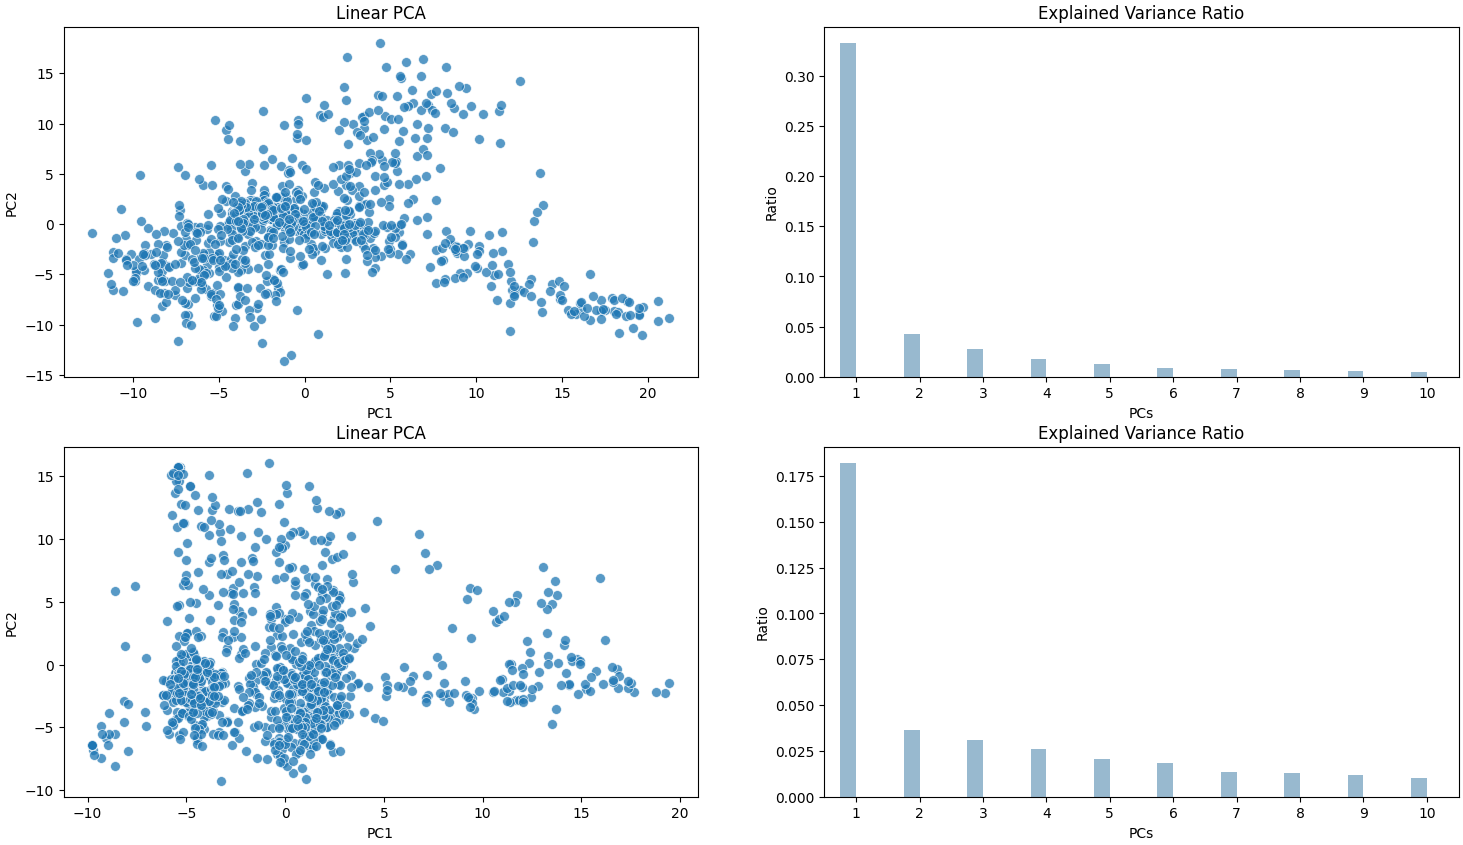

In [14]:
n = 10

df_pca_z, var_ratio_z = pca_wrapper_region(df_lung_double_z_roi.T,
                                            n = n)

df_pca_standard, var_ratio_standard = pca_wrapper_region(df_lung_standard_roi.T,
                                                          n = n)

fig, axes = plt.subplots(2,2, figsize=(18,10))

with plt.style.context('_classic_test_patch'):

    
    ## first row = double-z
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    data = df_pca_z,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[0,0])

    axes[0,0].set_title("Linear PCA", fontsize=12)
    axes[0,0].set_xlabel("PC1", fontsize=10)
    axes[0,0].set_ylabel("PC2", fontsize=10)
    
    
    sns.barplot(x = list(range(1, n+1)),
                    y = var_ratio_z,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[0,1])
    
    axes[0,1].set_title("Explained Variance Ratio", fontsize=12)
    axes[0,1].set_xlabel("PCs", fontsize=10)
    axes[0,1].set_ylabel("Ratio", fontsize=10)

    ## second row = standard
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    data = df_pca_standard,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[1,0])

    axes[1,0].set_title("Linear PCA", fontsize=12)
    axes[1,0].set_xlabel("PC1", fontsize=10)
    axes[1,0].set_ylabel("PC2", fontsize=10)
    
    
    sns.barplot(x = list(range(1, n+1)),
                    y = var_ratio_standard,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[1,1])
    
    axes[1,1].set_title("Explained Variance Ratio", fontsize=12)
    axes[1,1].set_xlabel("PCs", fontsize=10)
    axes[1,1].set_ylabel("Ratio", fontsize=10)

## Linear PCA + UMAP

- Use standard scaling or double-z scores
- Perform linear PCA and use the top 10-20 PCs
- Perform UMAP in the PC-space

### Samples

In [15]:
# Remove positive control regions
umap_lung_z, pca_lung_z = umap_wrapper(df_lung_double_z.drop([i for i in pos_control_in_s3 if i in df_lung_double_z], axis=1),
                                       df_lung_meta,
                                       n_pca=15,
                                       remove_PC1=False,
                                       n_neighbors=10,
                                       n_umap=3,
                                       learning_rate=0.1,
                                       min_dist=0.1,
                                       spread=1,
                                       metric="euclidean",
                                       random_state=42)




umap_lung_standard, pca_lung_standard = umap_wrapper(df_lung_standard.drop([i for i in pos_control_in_s3 if i in df_lung_standard], axis=1),
                                                     df_lung_meta,
                                                     n_pca=10,
                                                     remove_PC1=False,
                                                     n_neighbors=15,
                                                     n_umap=3,
                                                     learning_rate=0.1,
                                                     min_dist=0.1,
                                                     spread=1,
                                                     metric="euclidean",
                                                     random_state=42)

Input data dimension: (996, 21824)
Input meta-data dimension: (996, 14)
Dimension after merging: (996, 17)
Input data dimension: (996, 21824)
Input meta-data dimension: (996, 14)
Dimension after merging: (996, 17)


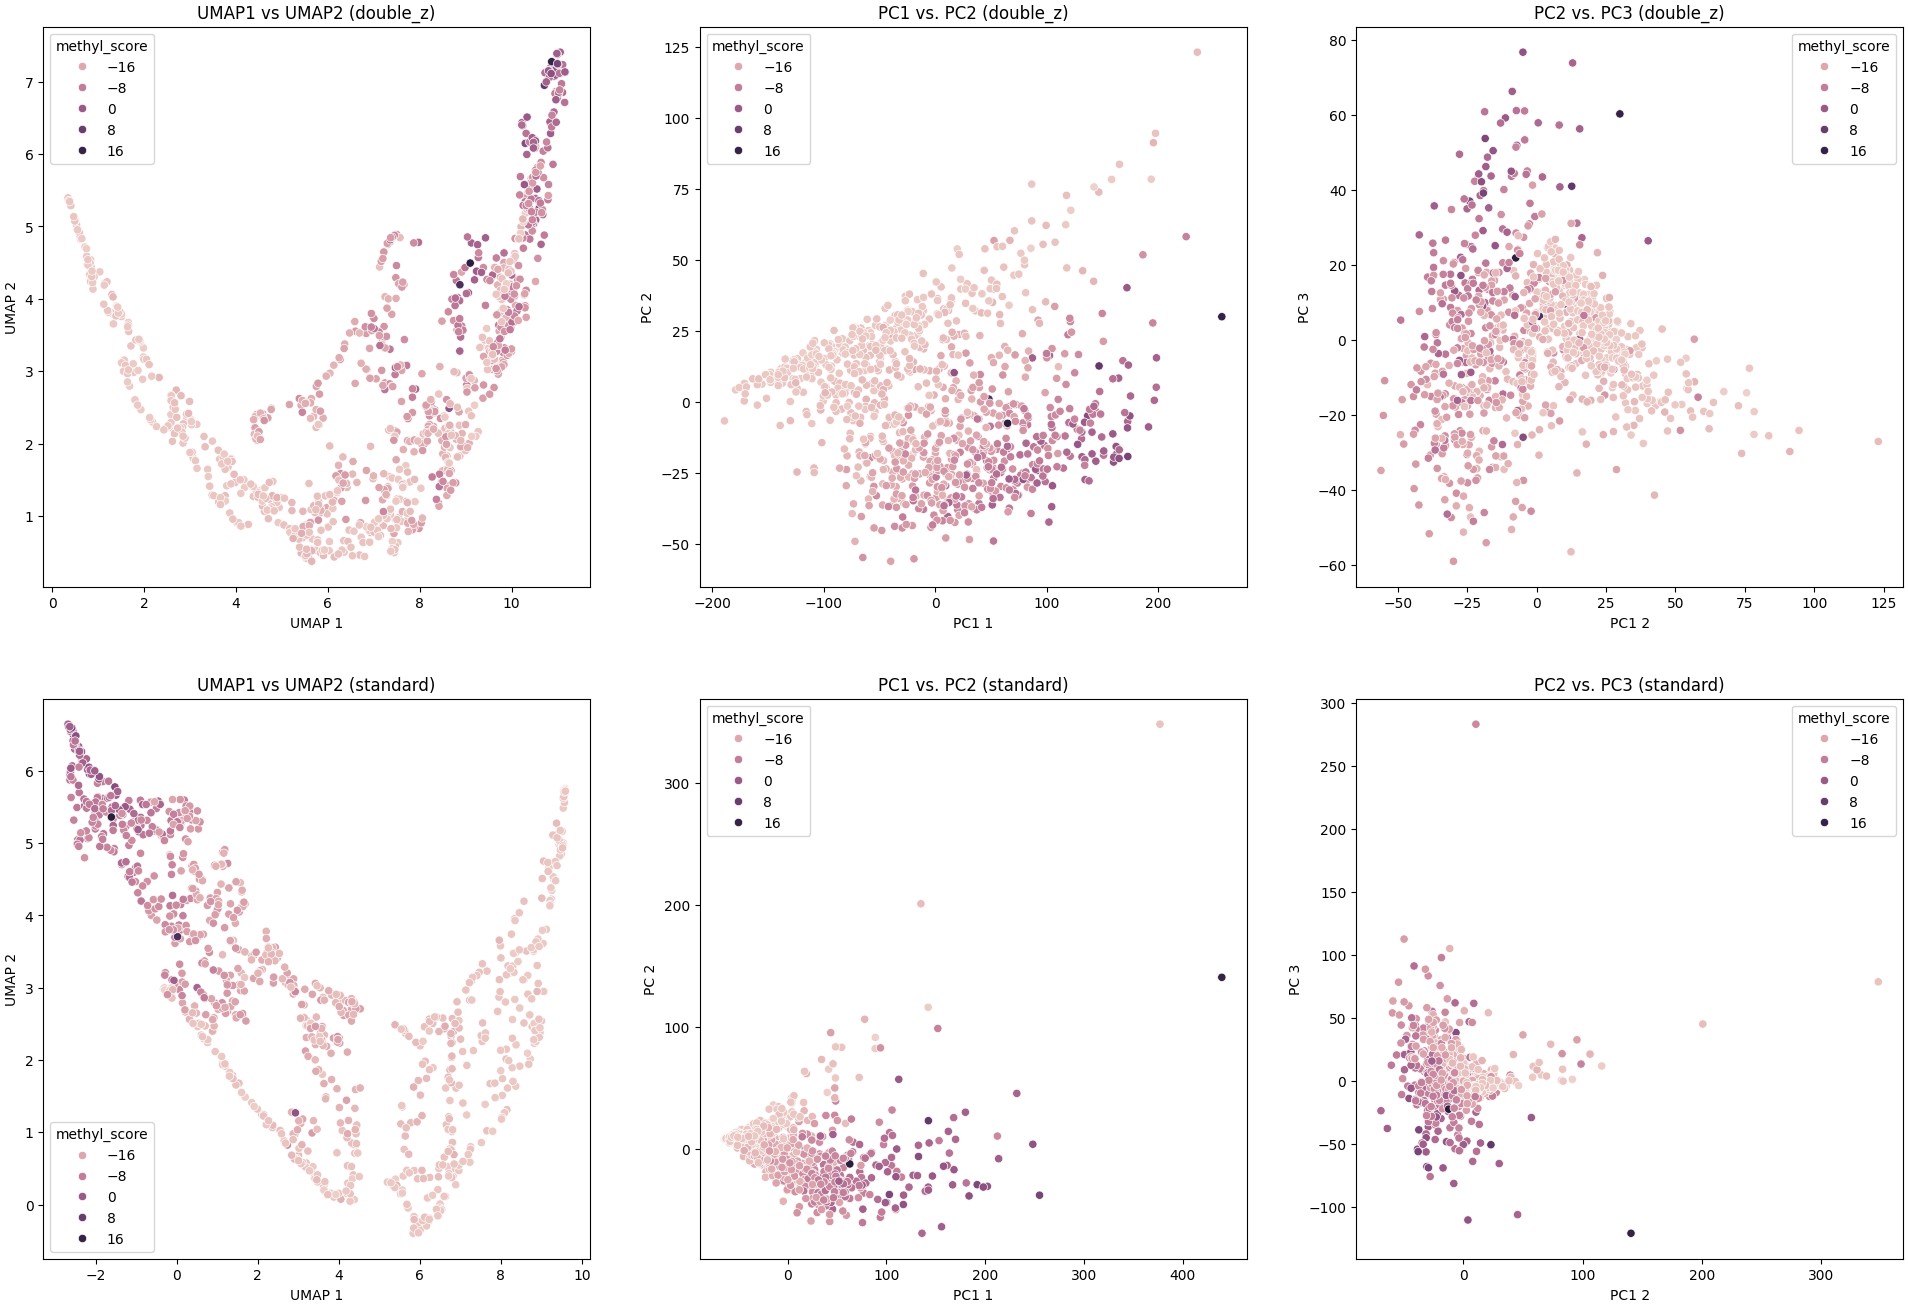

In [16]:
hue = "methyl_score"

fig, axes = plt.subplots(2,3, figsize=(24,16))
with plt.style.context('_classic_test_patch'):

    ## UMAP 1 vs. UMAP 2

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_lung_z,
                    ax = axes[0,0])
        
    axes[0,0].set_title("UMAP1 vs UMAP2 (double_z)", fontsize=12)
    axes[0,0].set_xlabel("UMAP 1", fontsize=10)
    axes[0,0].set_ylabel("UMAP 2", fontsize=10)
    
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_lung_standard,
                    ax = axes[1,0])
        
    axes[1,0].set_title("UMAP1 vs UMAP2 (standard)", fontsize=12)
    axes[1,0].set_xlabel("UMAP 1", fontsize=10)
    axes[1,0].set_ylabel("UMAP 2", fontsize=10)


    
    ## PC 1 vs. PC 2
    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_lung_z,
                    ax = axes[0,1])
        
    axes[0,1].set_title("PC1 vs. PC2 (double_z)", fontsize=12)
    axes[0,1].set_xlabel("PC1 1", fontsize=10)
    axes[0,1].set_ylabel("PC 2", fontsize=10)

    
    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_lung_standard,
                    ax = axes[1,1])
        
    axes[1,1].set_title("PC1 vs. PC2 (standard)", fontsize=12)
    axes[1,1].set_xlabel("PC1 1", fontsize=10)
    axes[1,1].set_ylabel("PC 2", fontsize=10)
    



    ## PC 2 vs. PC 3
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_lung_z,
                    ax = axes[0,2])
        
    axes[0,2].set_title("PC2 vs. PC3 (double_z)", fontsize=12)
    axes[0,2].set_xlabel("PC1 2", fontsize=10)
    axes[0,2].set_ylabel("PC 3", fontsize=10)
    
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_lung_standard,
                    ax = axes[1,2])
        
    axes[1,2].set_title("PC2 vs. PC3 (standard)", fontsize=12)
    axes[1,2].set_xlabel("PC1 2", fontsize=10)
    axes[1,2].set_ylabel("PC 3", fontsize=10)

### Regions

#### All regions

In [17]:
umap_lung_z_region, pca_lung_z_region = umap_wrapper(df_lung_double_z.T,
                                                   df_meta=region_anno_all,
                                                   n_pca=15,
                                                   remove_PC1=False,
                                                   n_neighbors=15,
                                                   n_umap=3,
                                                   learning_rate=0.1,
                                                   min_dist=0.1,
                                                   spread=1,
                                                   metric="euclidean",
                                                   random_state=42)

umap_lung_standard_region, pca_lung_standard_region = umap_wrapper(df_lung_standard.T,
                                                                 df_meta=region_anno_all,
                                                                 n_pca=15,
                                                                 remove_PC1=False,
                                                                 n_neighbors=15,
                                                                 n_umap=3,
                                                                 learning_rate=0.1,
                                                                 min_dist=0.1,
                                                                 spread=1,
                                                                 metric="euclidean",
                                                                 random_state=42)

Input data dimension: (21824, 996)
Input meta-data dimension: (21824, 4)
Dimension after merging: (21824, 7)
Input data dimension: (21824, 996)
Input meta-data dimension: (21824, 4)
Dimension after merging: (21824, 7)


In [18]:
region_anno_all.head()

region_score_median  standard_median  double_z_median  \
s3_region_1                 -5.0        -0.173204        -0.130698   
s3_region_2                 -5.0        -0.287269        -0.203264   
s3_region_3                 -5.0        -0.069808         0.042931   
s3_region_4                 -5.0        -0.148563        -0.066986   
s3_region_5                 -5.0        -0.059923         0.035229   

             pos_control  
s3_region_1            0  
s3_region_2            0  
s3_region_3            0  
s3_region_4            0  
s3_region_5            0

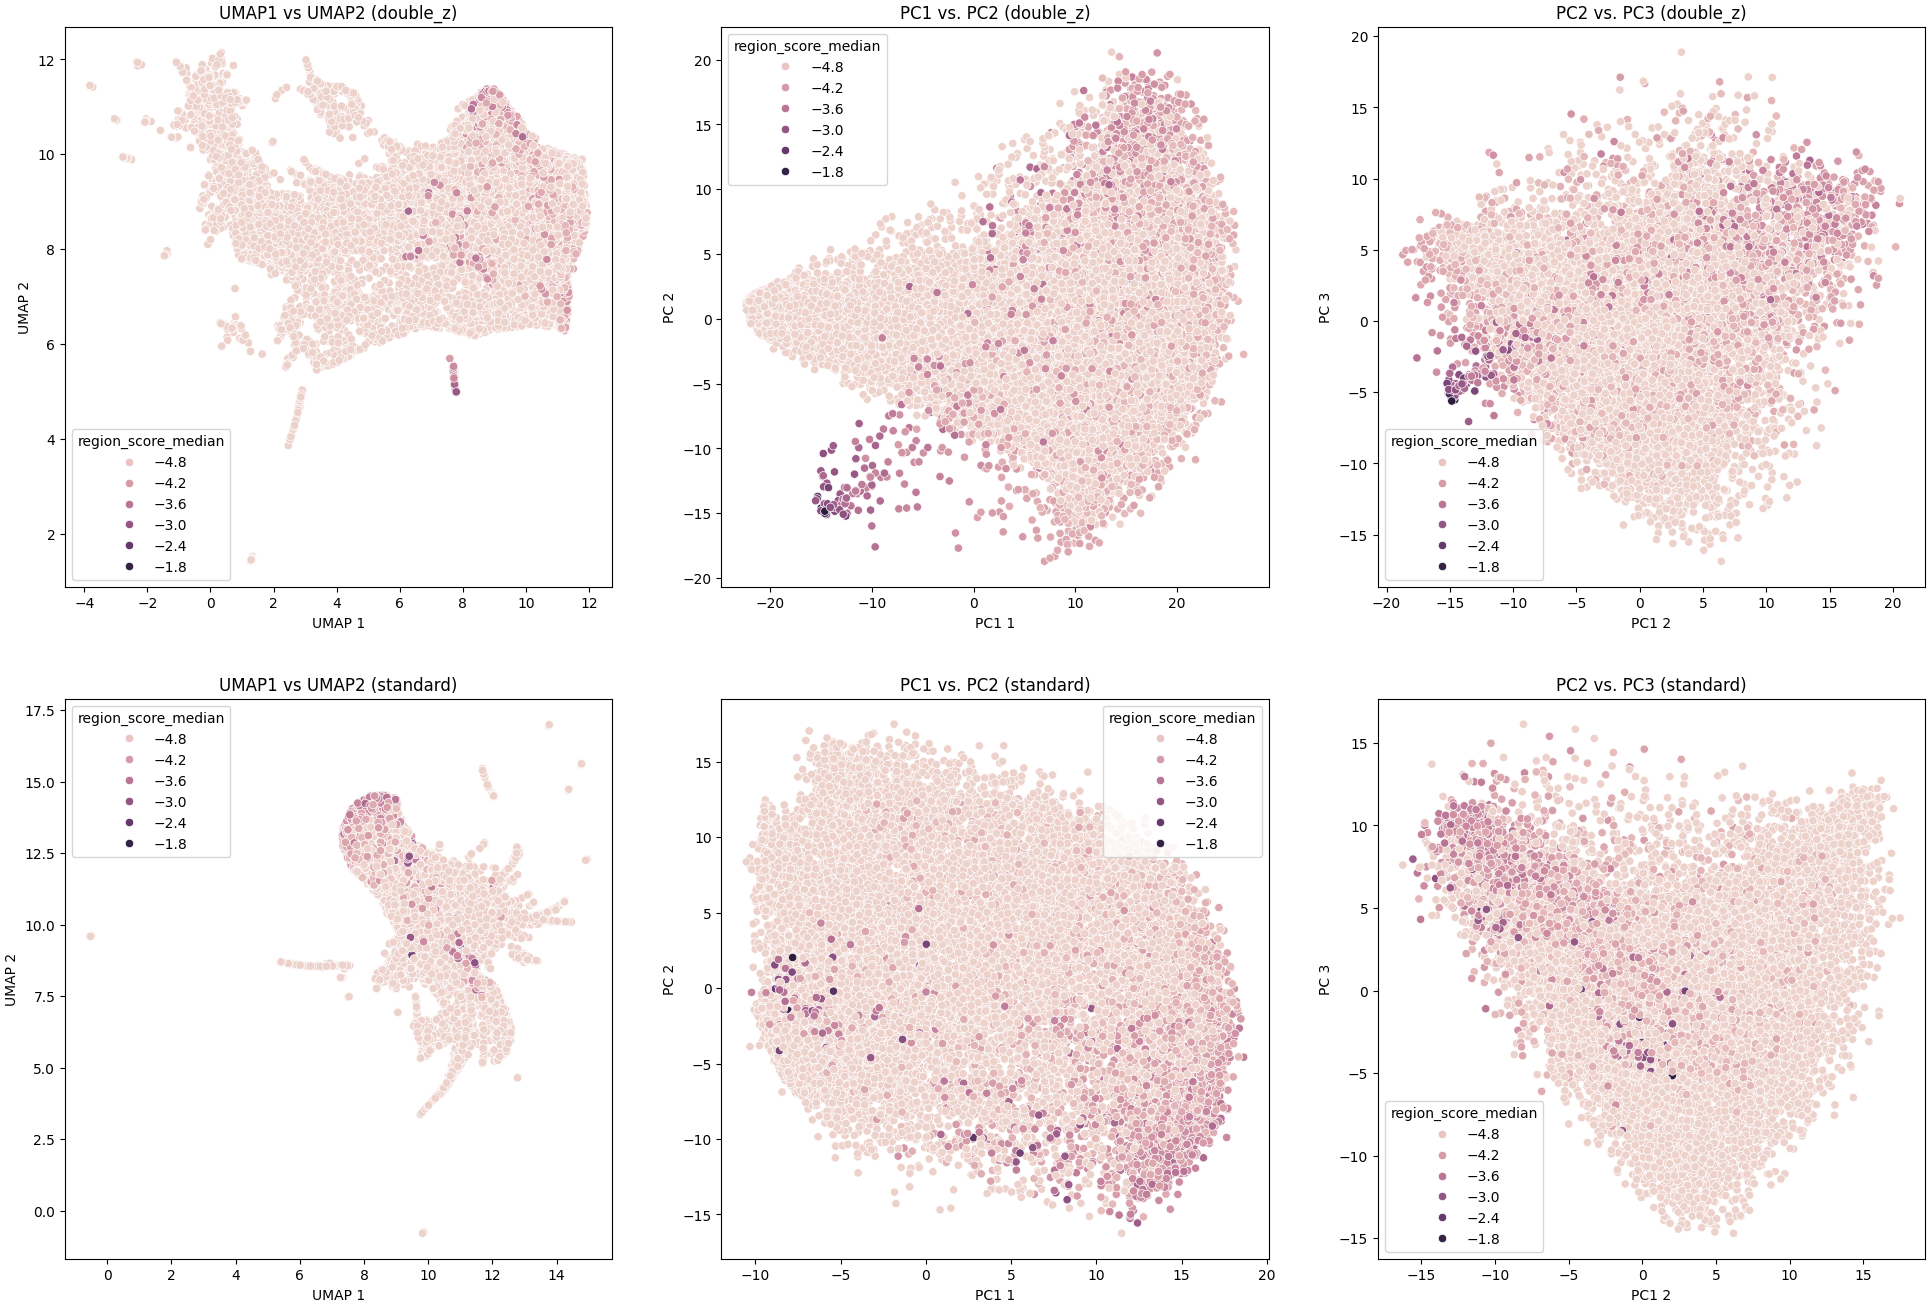

In [19]:
hue = "region_score_median"

fig, axes = plt.subplots(2,3, figsize=(24,16))
with plt.style.context('_classic_test_patch'):

    ## UMAP 1 vs. UMAP 2
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_lung_z_region,
                    ax = axes[0,0])
        
    axes[0,0].set_title("UMAP1 vs UMAP2 (double_z)", fontsize=12)
    axes[0,0].set_xlabel("UMAP 1", fontsize=10)
    axes[0,0].set_ylabel("UMAP 2", fontsize=10)
    
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_lung_standard_region,
                    ax = axes[1,0])
        
    axes[1,0].set_title("UMAP1 vs UMAP2 (standard)", fontsize=12)
    axes[1,0].set_xlabel("UMAP 1", fontsize=10)
    axes[1,0].set_ylabel("UMAP 2", fontsize=10)


    ## PC 1 vs. PC 2
    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_lung_z_region,
                    ax = axes[0,1])
        
    axes[0,1].set_title("PC1 vs. PC2 (double_z)", fontsize=12)
    axes[0,1].set_xlabel("PC1 1", fontsize=10)
    axes[0,1].set_ylabel("PC 2", fontsize=10)

    
    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_lung_standard_region,
                    ax = axes[1,1])
        
    axes[1,1].set_title("PC1 vs. PC2 (standard)", fontsize=12)
    axes[1,1].set_xlabel("PC1 1", fontsize=10)
    axes[1,1].set_ylabel("PC 2", fontsize=10)



    ## PC 2 vs. PC 3
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_lung_z_region,
                    ax = axes[0,2])
        
    axes[0,2].set_title("PC2 vs. PC3 (double_z)", fontsize=12)
    axes[0,2].set_xlabel("PC1 2", fontsize=10)
    axes[0,2].set_ylabel("PC 3", fontsize=10)
    
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_lung_standard_region,
                    ax = axes[1,2])
        
    axes[1,2].set_title("PC2 vs. PC3 (standard)", fontsize=12)
    axes[1,2].set_xlabel("PC1 2", fontsize=10)
    axes[1,2].set_ylabel("PC 3", fontsize=10)


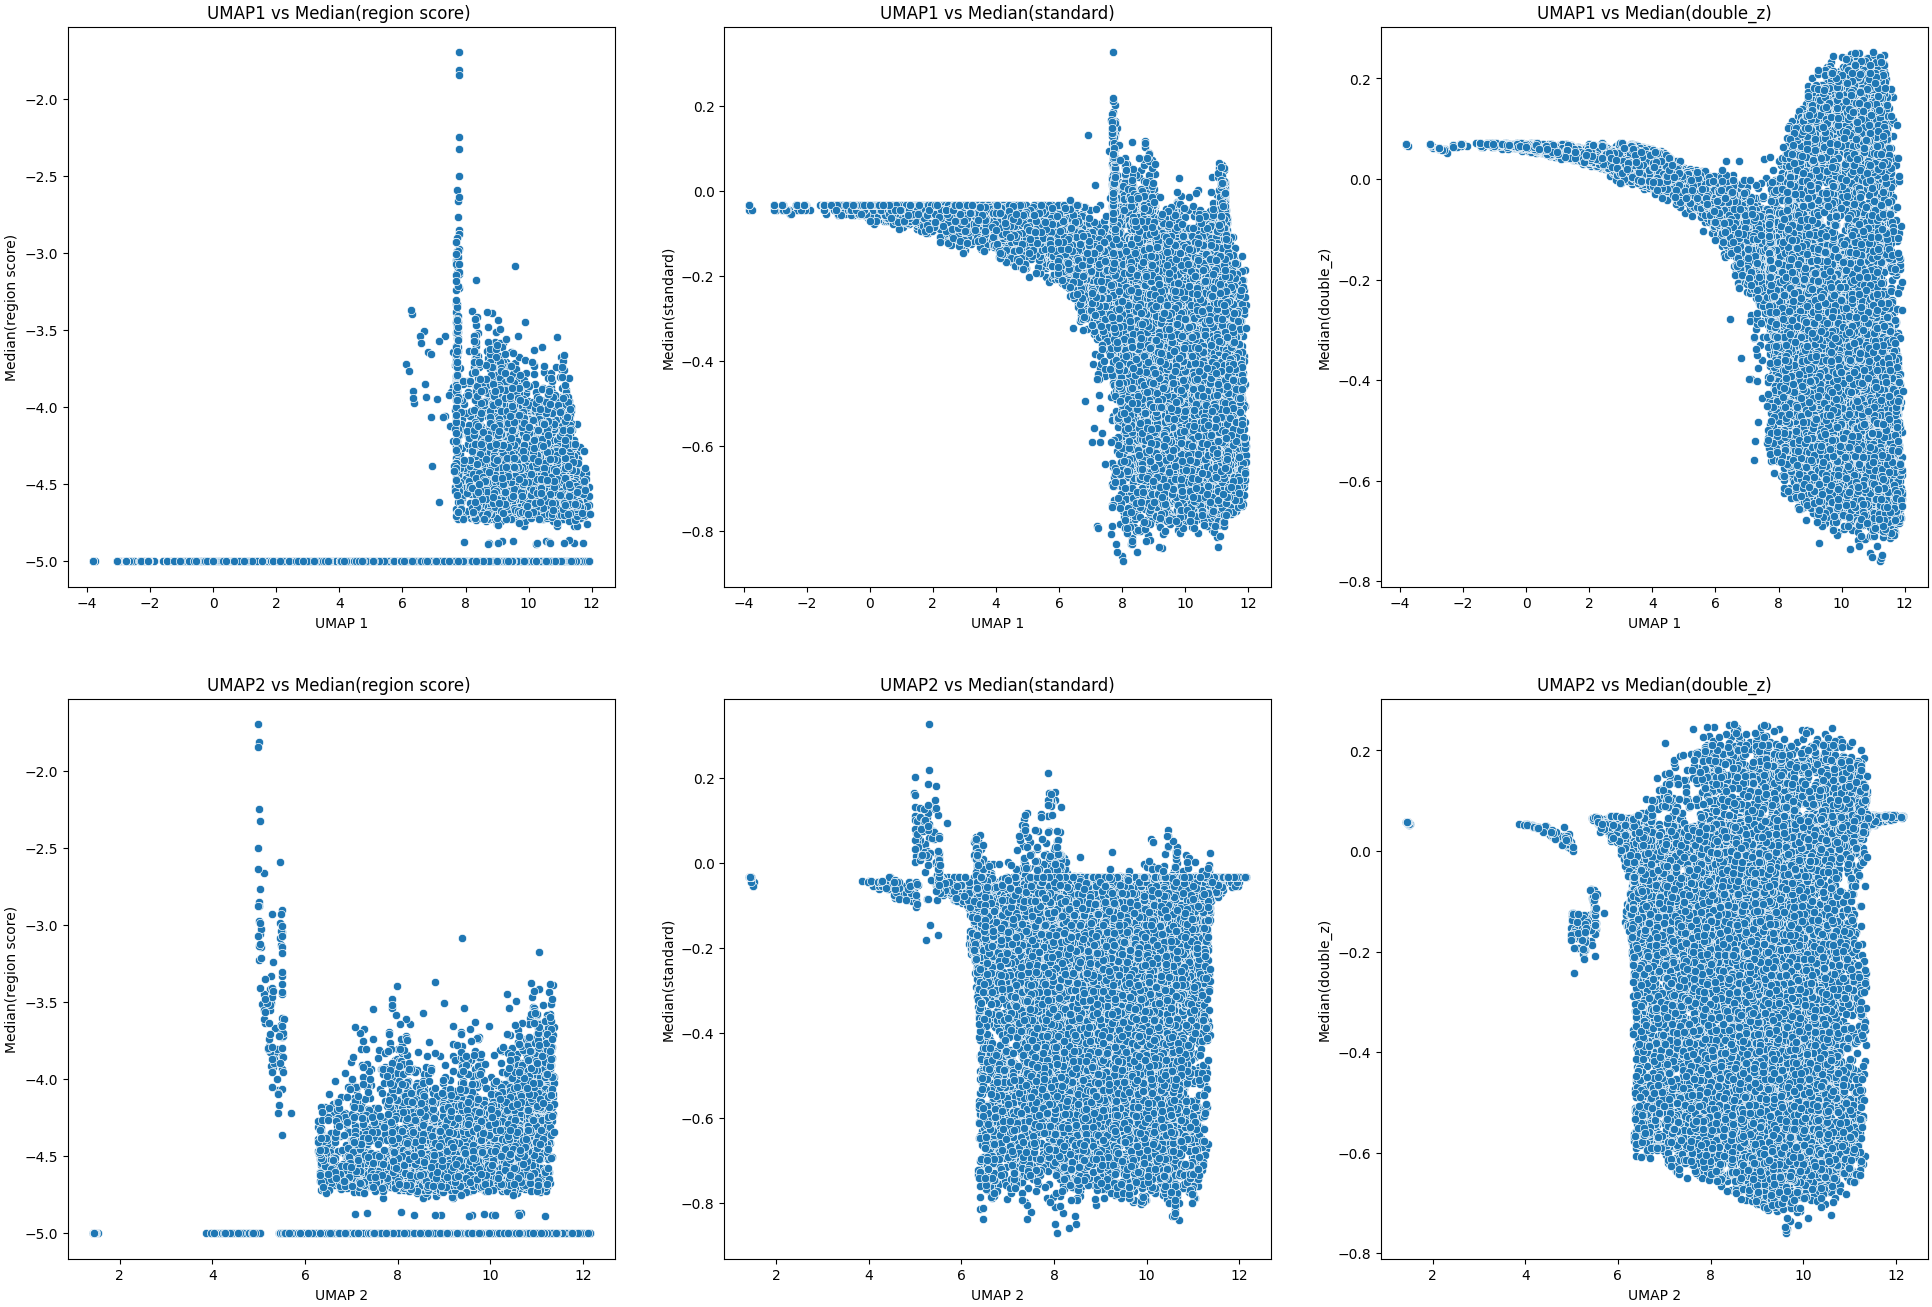

In [20]:
## Check the correlation between (UMAP1 & UMAP2) with coverage
## Use double-z scores + UMAP
hue = None

fig, axes = plt.subplots(2,3, figsize=(24,16))
with plt.style.context('_classic_test_patch'):

    ## UMAP1 vs. region score median
    sns.scatterplot(x = "UMAP1",
                    y = "region_score_median",
                    hue = hue,
                    data = umap_lung_z_region,
                    ax = axes[0,0])
        
    axes[0,0].set_title("UMAP1 vs Median(region score) ", fontsize=12)
    axes[0,0].set_xlabel("UMAP 1", fontsize=10)
    axes[0,0].set_ylabel("Median(region score)", fontsize=10)

    ## UMAP1 vs. standard scaling median
    sns.scatterplot(x = "UMAP1",
                    y = "standard_median",
                    hue = hue,
                    data = umap_lung_z_region,
                    ax = axes[0,1])
        
    axes[0,1].set_title("UMAP1 vs Median(standard)", fontsize=12)
    axes[0,1].set_xlabel("UMAP 1", fontsize=10)
    axes[0,1].set_ylabel("Median(standard)", fontsize=10)

    ## UMAP1 vs. double z
    sns.scatterplot(x = "UMAP1",
                    y = "double_z_median",
                    hue = hue,
                    data = umap_lung_z_region,
                    ax = axes[0,2])
        
    axes[0,2].set_title("UMAP1 vs Median(double_z)", fontsize=12)
    axes[0,2].set_xlabel("UMAP 1", fontsize=10)
    axes[0,2].set_ylabel("Median(double_z)", fontsize=10)

    
    
    ## UMAP2 vs. region score median
    sns.scatterplot(x = "UMAP2",
                    y = "region_score_median",
                    hue = hue,
                    data = umap_lung_z_region,
                    ax = axes[1,0])
        
    axes[1,0].set_title("UMAP2 vs Median(region score) ", fontsize=12)
    axes[1,0].set_xlabel("UMAP 2", fontsize=10)
    axes[1,0].set_ylabel("Median(region score)", fontsize=10)

    ## UMAP2 vs. standard scaling median
    sns.scatterplot(x = "UMAP2",
                    y = "standard_median",
                    hue = hue,
                    data = umap_lung_z_region,
                    ax = axes[1,1])
        
    axes[1,1].set_title("UMAP2 vs Median(standard)", fontsize=12)
    axes[1,1].set_xlabel("UMAP 2", fontsize=10)
    axes[1,1].set_ylabel("Median(standard)", fontsize=10)

    ## UMAP2 vs. double z
    sns.scatterplot(x = "UMAP2",
                    y = "double_z_median",
                    hue = hue,
                    data = umap_lung_z_region,
                    ax = axes[1,2])
        
    axes[1,2].set_title("UMAP2 vs Median(double_z)", fontsize=12)
    axes[1,2].set_xlabel("UMAP 2", fontsize=10)
    axes[1,2].set_ylabel("Median(double_z)", fontsize=10)

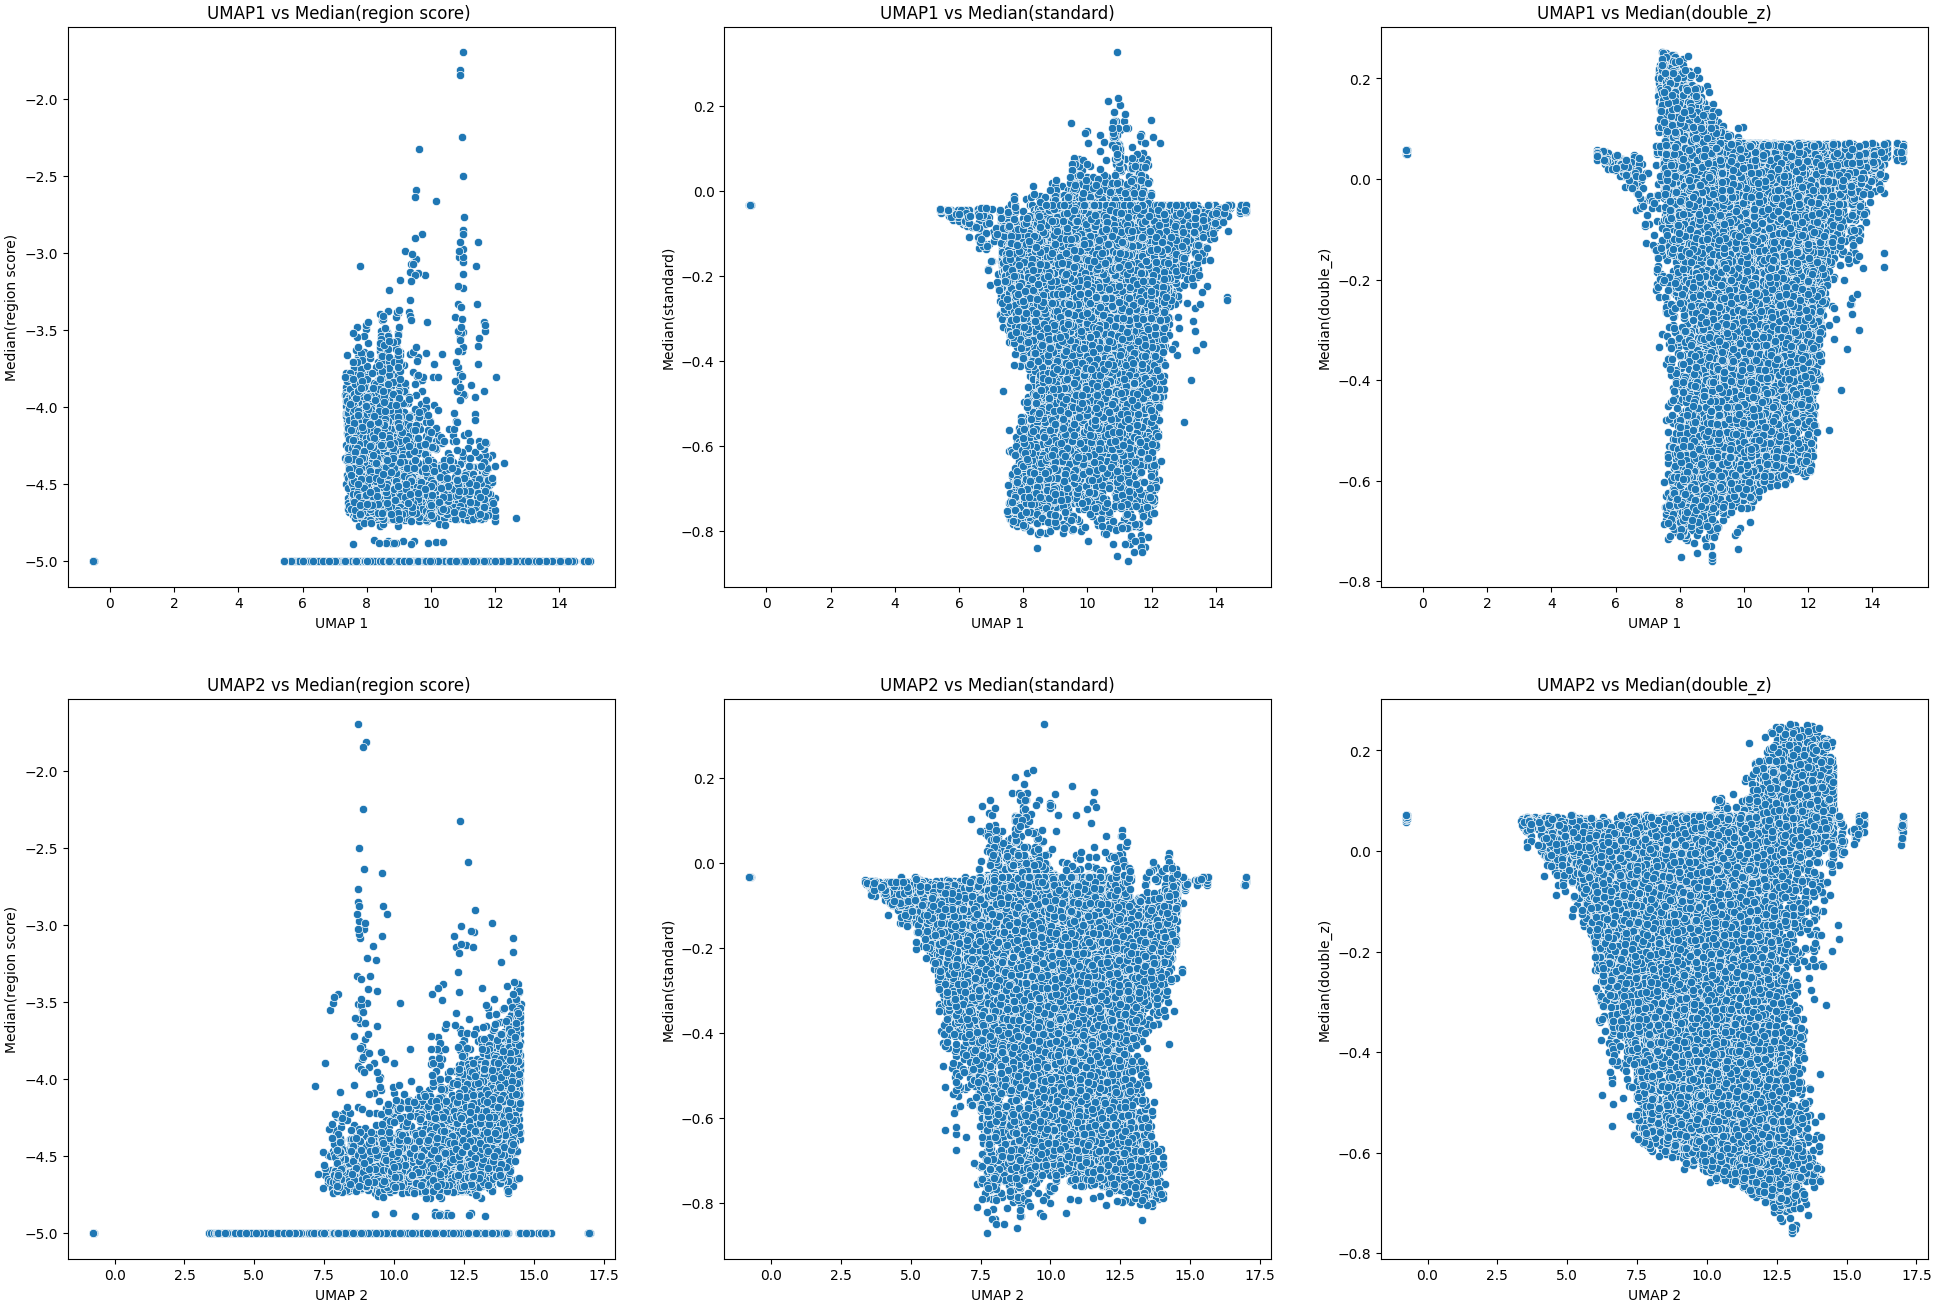

In [21]:
## Check the correlation between (UMAP1 & UMAP2) with coverage
## Use standard scaling + UMAP

hue = None

fig, axes = plt.subplots(2,3, figsize=(24,16))
with plt.style.context('_classic_test_patch'):

    ## UMAP1 vs. region score median
    sns.scatterplot(x = "UMAP1",
                    y = "region_score_median",
                    hue = hue,
                    data = umap_lung_standard_region,
                    ax = axes[0,0])
        
    axes[0,0].set_title("UMAP1 vs Median(region score) ", fontsize=12)
    axes[0,0].set_xlabel("UMAP 1", fontsize=10)
    axes[0,0].set_ylabel("Median(region score)", fontsize=10)

    ## UMAP1 vs. standard scaling median
    sns.scatterplot(x = "UMAP1",
                    y = "standard_median",
                    hue = hue,
                    data = umap_lung_standard_region,
                    ax = axes[0,1])
        
    axes[0,1].set_title("UMAP1 vs Median(standard)", fontsize=12)
    axes[0,1].set_xlabel("UMAP 1", fontsize=10)
    axes[0,1].set_ylabel("Median(standard)", fontsize=10)

    ## UMAP1 vs. double z
    sns.scatterplot(x = "UMAP1",
                    y = "double_z_median",
                    hue = hue,
                    data = umap_lung_standard_region,
                    ax = axes[0,2])
        
    axes[0,2].set_title("UMAP1 vs Median(double_z)", fontsize=12)
    axes[0,2].set_xlabel("UMAP 1", fontsize=10)
    axes[0,2].set_ylabel("Median(double_z)", fontsize=10)

    
    
    ## UMAP2 vs. region score median
    sns.scatterplot(x = "UMAP2",
                    y = "region_score_median",
                    hue = hue,
                    data = umap_lung_standard_region,
                    ax = axes[1,0])
        
    axes[1,0].set_title("UMAP2 vs Median(region score) ", fontsize=12)
    axes[1,0].set_xlabel("UMAP 2", fontsize=10)
    axes[1,0].set_ylabel("Median(region score)", fontsize=10)

    ## UMAP2 vs. standard scaling median
    sns.scatterplot(x = "UMAP2",
                    y = "standard_median",
                    hue = hue,
                    data = umap_lung_standard_region,
                    ax = axes[1,1])
        
    axes[1,1].set_title("UMAP2 vs Median(standard)", fontsize=12)
    axes[1,1].set_xlabel("UMAP 2", fontsize=10)
    axes[1,1].set_ylabel("Median(standard)", fontsize=10)

    ## UMAP2 vs. double z
    sns.scatterplot(x = "UMAP2",
                    y = "double_z_median",
                    hue = hue,
                    data = umap_lung_standard_region,
                    ax = axes[1,2])
        
    axes[1,2].set_title("UMAP2 vs Median(double_z)", fontsize=12)
    axes[1,2].set_xlabel("UMAP 2", fontsize=10)
    axes[1,2].set_ylabel("Median(double_z)", fontsize=10)

#### Regions of interest

In [22]:
umap_lung_z_region_roi, pca_lung_z_region_roi = umap_wrapper(df_lung_double_z_roi.T,
                                                         df_meta=region_anno,
                                                         n_pca=15,
                                                         remove_PC1=False,
                                                         n_neighbors=10,
                                                         n_umap=3,
                                                         learning_rate=0.1,
                                                         min_dist=0.1,
                                                         spread=1,
                                                        metric="euclidean",
                                                        random_state=42)

umap_lung_standard_region_roi, pca_lung_standard_region_roi = umap_wrapper(df_lung_standard_roi.T,
                                                                       df_meta=region_anno,
                                                                       n_pca=15,
                                                                       remove_PC1=False,
                                                                       n_neighbors=10,
                                                                       n_umap=3,
                                                                       learning_rate=0.1,
                                                                       min_dist=0.1,
                                                                       spread=1,
                                                                       metric="euclidean",
                                                                       random_state=42)

Input data dimension: (1003, 996)
Input meta-data dimension: (1028, 19)
Dimension after merging: (1003, 22)
Input data dimension: (1003, 996)
Input meta-data dimension: (1028, 19)
Dimension after merging: (1003, 22)


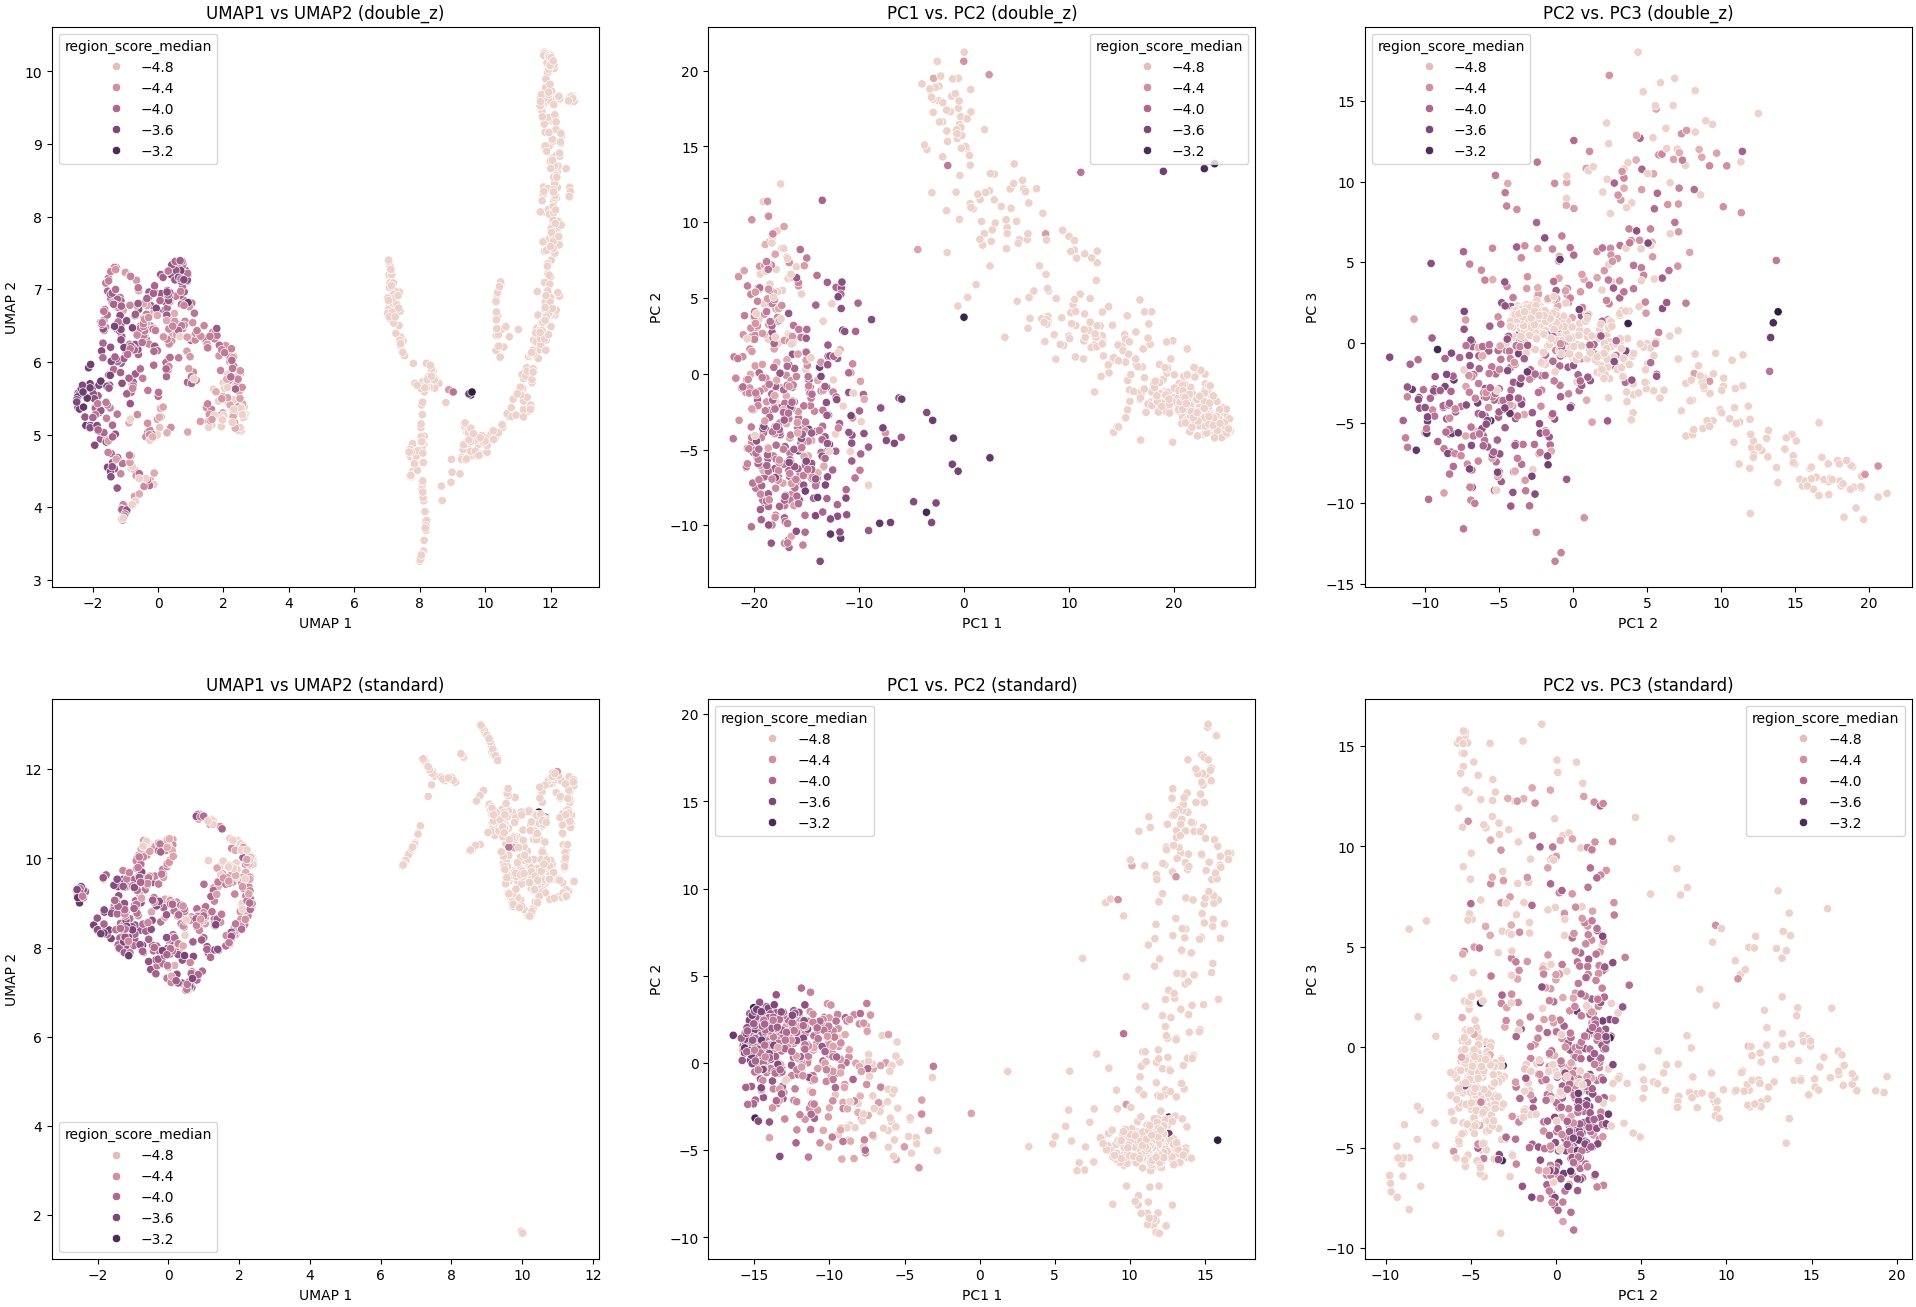

In [23]:
hue = "region_score_median"

fig, axes = plt.subplots(2,3, figsize=(24,16))
with plt.style.context('_classic_test_patch'):

    ## UMAP 1 vs. UMAP 2

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_lung_z_region_roi,
                    ax = axes[0,0])
        
    axes[0,0].set_title("UMAP1 vs UMAP2 (double_z)", fontsize=12)
    axes[0,0].set_xlabel("UMAP 1", fontsize=10)
    axes[0,0].set_ylabel("UMAP 2", fontsize=10)
    
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_lung_standard_region_roi,
                    ax = axes[1,0])
        
    axes[1,0].set_title("UMAP1 vs UMAP2 (standard)", fontsize=12)
    axes[1,0].set_xlabel("UMAP 1", fontsize=10)
    axes[1,0].set_ylabel("UMAP 2", fontsize=10)



    ## PC 1 vs. PC 2
    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_lung_z_region_roi,
                    ax = axes[0,1])
        
    axes[0,1].set_title("PC1 vs. PC2 (double_z)", fontsize=12)
    axes[0,1].set_xlabel("PC1 1", fontsize=10)
    axes[0,1].set_ylabel("PC 2", fontsize=10)

    
    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_lung_standard_region_roi,
                    ax = axes[1,1])
        
    axes[1,1].set_title("PC1 vs. PC2 (standard)", fontsize=12)
    axes[1,1].set_xlabel("PC1 1", fontsize=10)
    axes[1,1].set_ylabel("PC 2", fontsize=10)



    ## PC 2 vs. PC 3
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_lung_z_region_roi,
                    ax = axes[0,2])
        
    axes[0,2].set_title("PC2 vs. PC3 (double_z)", fontsize=12)
    axes[0,2].set_xlabel("PC1 2", fontsize=10)
    axes[0,2].set_ylabel("PC 3", fontsize=10)
    
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_lung_standard_region_roi,
                    ax = axes[1,2])
        
    axes[1,2].set_title("PC2 vs. PC3 (standard)", fontsize=12)
    axes[1,2].set_xlabel("PC1 2", fontsize=10)
    axes[1,2].set_ylabel("PC 3", fontsize=10)

## K-Means + Elbow Method on UMAP (on doulbe-z scores)

### Samples

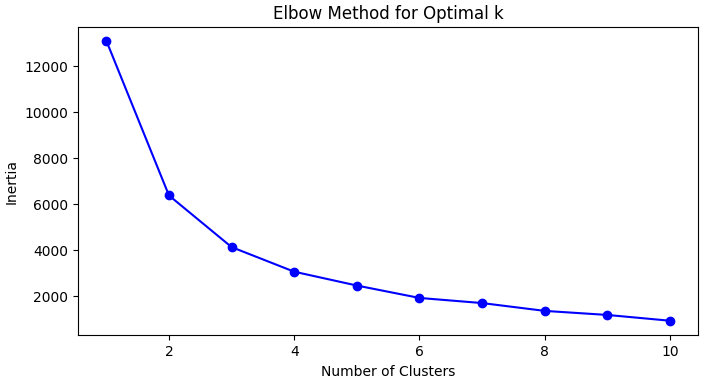

In [24]:
max_k = 10

X_lung_z = umap_lung_z.drop(pdata_lung,axis=1)

## Use elbow method to find the optimal number of clusters
inertia = []

for k in range(1,max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_lung_z)
    inertia.append(kmeans.inertia_)

fig, axes = plt.subplots(figsize=(8,4))

with plt.style.context('_classic_test_patch'):
    axes.plot(range(1, max_k+1),inertia, 'bo-')
    axes.set_xlabel("Number of Clusters")
    axes.set_ylabel("Inertia")
    axes.set_title("Elbow Method for Optimal k")

In [25]:
run = True
file_name = '/screening/notebooks/zhuang/summer_2024/data/' + "X_lung_z.pkl"

if run:
    ## Use optimal k for k-means
    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_lung_z)
    X_lung_z['kmeans_cluster'] = kmeans.fit_predict(X_lung_z.values)
    
    ## DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    X_lung_z['dbscan_cluster'] = dbscan.fit_predict(X_lung_z.values)
            
    with open(file_name, 'wb') as f:
        pickle.dump(X_lung_z, f)

else:
    with open(file_name, 'rb') as f:
        X_lung_z = pickle.load(f)

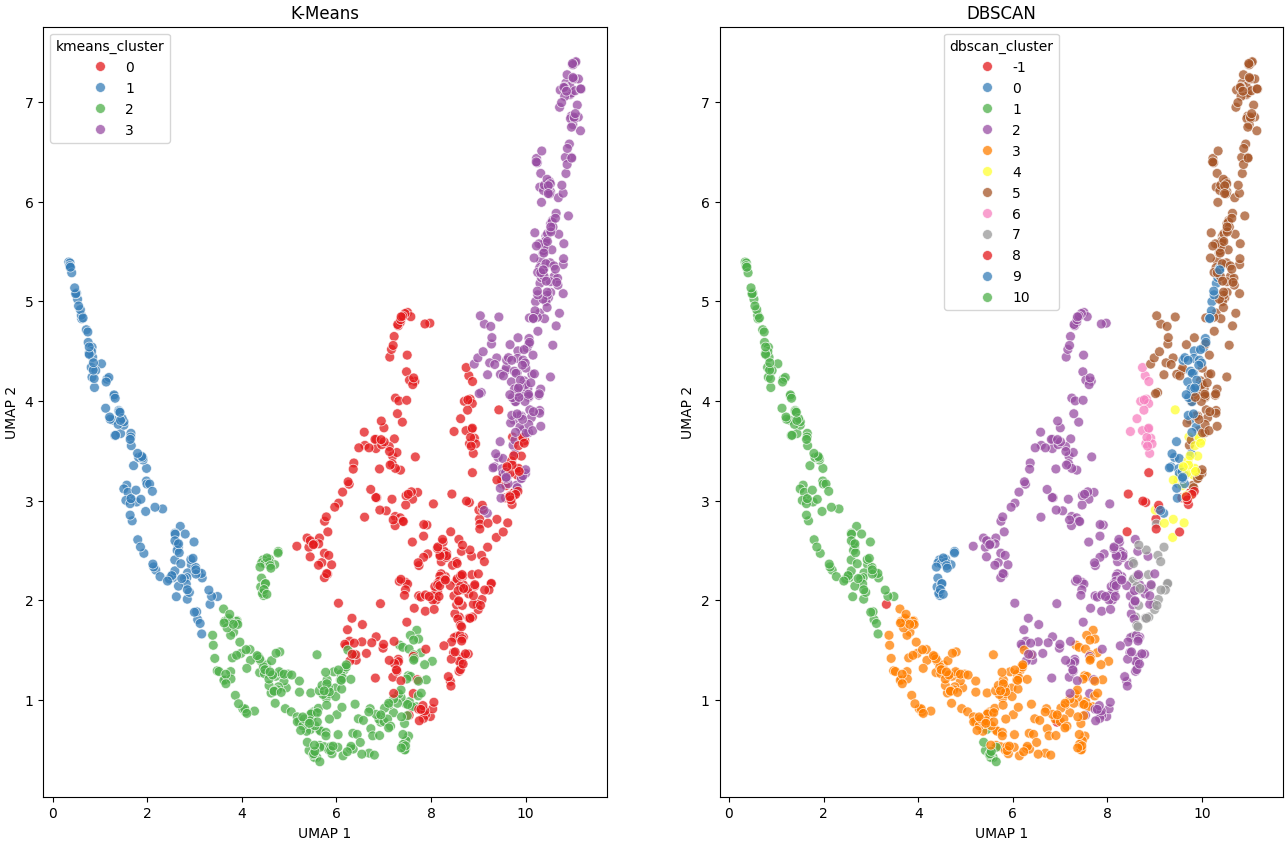

In [26]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

with plt.style.context('_classic_test_patch'):
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "kmeans_cluster",
                    data = X_lung_z,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[0])
    
    axes[0].set_title("K-Means", fontsize=12)
    axes[0].set_xlabel("UMAP 1", fontsize=10)
    axes[0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "dbscan_cluster",
                    data = X_lung_z,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[1])
    
    axes[1].set_title("DBSCAN", fontsize=12)
    axes[1].set_xlabel("UMAP 1", fontsize=10)
    axes[1].set_ylabel("UMAP 2", fontsize=10)

In [27]:
df = pd.merge(X_lung_z, df_lung_meta, how="left", left_index=True, right_index=True).\
    assign(log10_tumor_fraction = lambda df: np.log10(df["tumor_fraction"]))
df.head()

UMAP1     UMAP2     UMAP3  \
unique_sample_id                                                         
A093927901_240223_A01613_0332_BHTFLTDSX7  9.188663  2.873134  6.875479   
A094083701_240129_A01361_0596_BHNMWYDSX7  1.985634  3.323323  6.942068   
A094183601_240125_A02048_0109_BHMMY2DSX7  1.567440  3.155297  6.616218   
A094216901_240125_A02019_0035_AHMHTCDSX7  7.223985  3.619664  3.247885   
A094245801_240201_A01613_0316_BHNMWCDSX7  5.645014  0.542674  7.599076   

                                          kmeans_cluster  dbscan_cluster  \
unique_sample_id                                                           
A093927901_240223_A01613_0332_BHTFLTDSX7               3               0   
A094083701_240129_A01361_0596_BHNMWYDSX7               1               1   
A094183601_240125_A02048_0109_BHMMY2DSX7               1               1   
A094216901_240125_A02019_0035_AHMHTCDSX7               0               2   
A094245801_240201_A01613_0316_BHNMWCDSX7               2               3   

                                         sample_group   age sex  \
unique_sample_id                                                  
A093927901_240223_A01613_0332_BHTFLTDSX7         lung  81.0   F   
A094083701_240129_A01361_0596_BHNMWYDSX7         lung  65.0   F   
A094183601_240125_A02048_0109_BHMMY2DSX7         lung  58.0   F   
A094216901_240125_A02019_0035_AHMHTCDSX7         lung  71.0   M   
A094245801_240201_A01613_0316_BHNMWCDSX7         lung  75.0   F   

                                         histological_subtype  \
unique_sample_id                                                
A093927901_240223_A01613_0332_BHTFLTDSX7       adenocarcinoma   
A094083701_240129_A01361_0596_BHNMWYDSX7       adenocarcinoma   
A094183601_240125_A02048_0109_BHMMY2DSX7       adenocarcinoma   
A094216901_240125_A02019_0035_AHMHTCDSX7              unknown   
A094245801_240201_A01613_0316_BHNMWCDSX7       adenocarcinoma   

                                          g360_max_maf_pct  tvf_max_maf_pct  \
unique_sample_id                                                              
A093927901_240223_A01613_0332_BHTFLTDSX7              48.2              NaN   
A094083701_240129_A01361_0596_BHNMWYDSX7               0.9         0.205973   
A094183601_240125_A02048_0109_BHMMY2DSX7               0.4              NaN   
A094216901_240125_A02019_0035_AHMHTCDSX7              16.5         0.180288   
A094245801_240201_A01613_0316_BHNMWCDSX7               0.2         0.218031   

                                          log_g360_maf  log_tvf_maf called  \
unique_sample_id                                                             
A093927901_240223_A01613_0332_BHTFLTDSX7      3.875359          NaN     TP   
A094083701_240129_A01361_0596_BHNMWYDSX7     -0.105361    -1.580010     TP   
A094183601_240125_A02048_0109_BHMMY2DSX7     -0.916291          NaN     TP   
A094216901_240125_A02019_0035_AHMHTCDSX7      2.803360    -1.713200     TP   
A094245801_240201_A01613_0316_BHNMWCDSX7     -1.609438    -1.523118     TP   

                                          tumor_fraction  log_tumor_fraction  \
unique_sample_id                                                               
A093927901_240223_A01613_0332_BHTFLTDSX7        0.001220           -6.708925   
A094083701_240129_A01361_0596_BHNMWYDSX7        0.000061           -9.701872   
A094183601_240125_A02048_0109_BHMMY2DSX7        0.000251           -8.289718   
A094216901_240125_A02019_0035_AHMHTCDSX7        0.237469           -1.437718   
A094245801_240201_A01613_0316_BHNMWCDSX7        0.000189           -8.574908   

                                          methyl_score  threshold  \
unique_sample_id                                                    
A093927901_240223_A01613_0332_BHTFLTDSX7    -18.371179   -21.3192   
A094083701_240129_A01361_0596_BHNMWYDSX7    -22.631519   -21.3192   
A094183601_240125_A02048_0109_BHMMY2DSX7    -22.226209   -21.3192   
A094216901_240125_A02019_0035_AHMHTCDSX7    -12.771072   -21

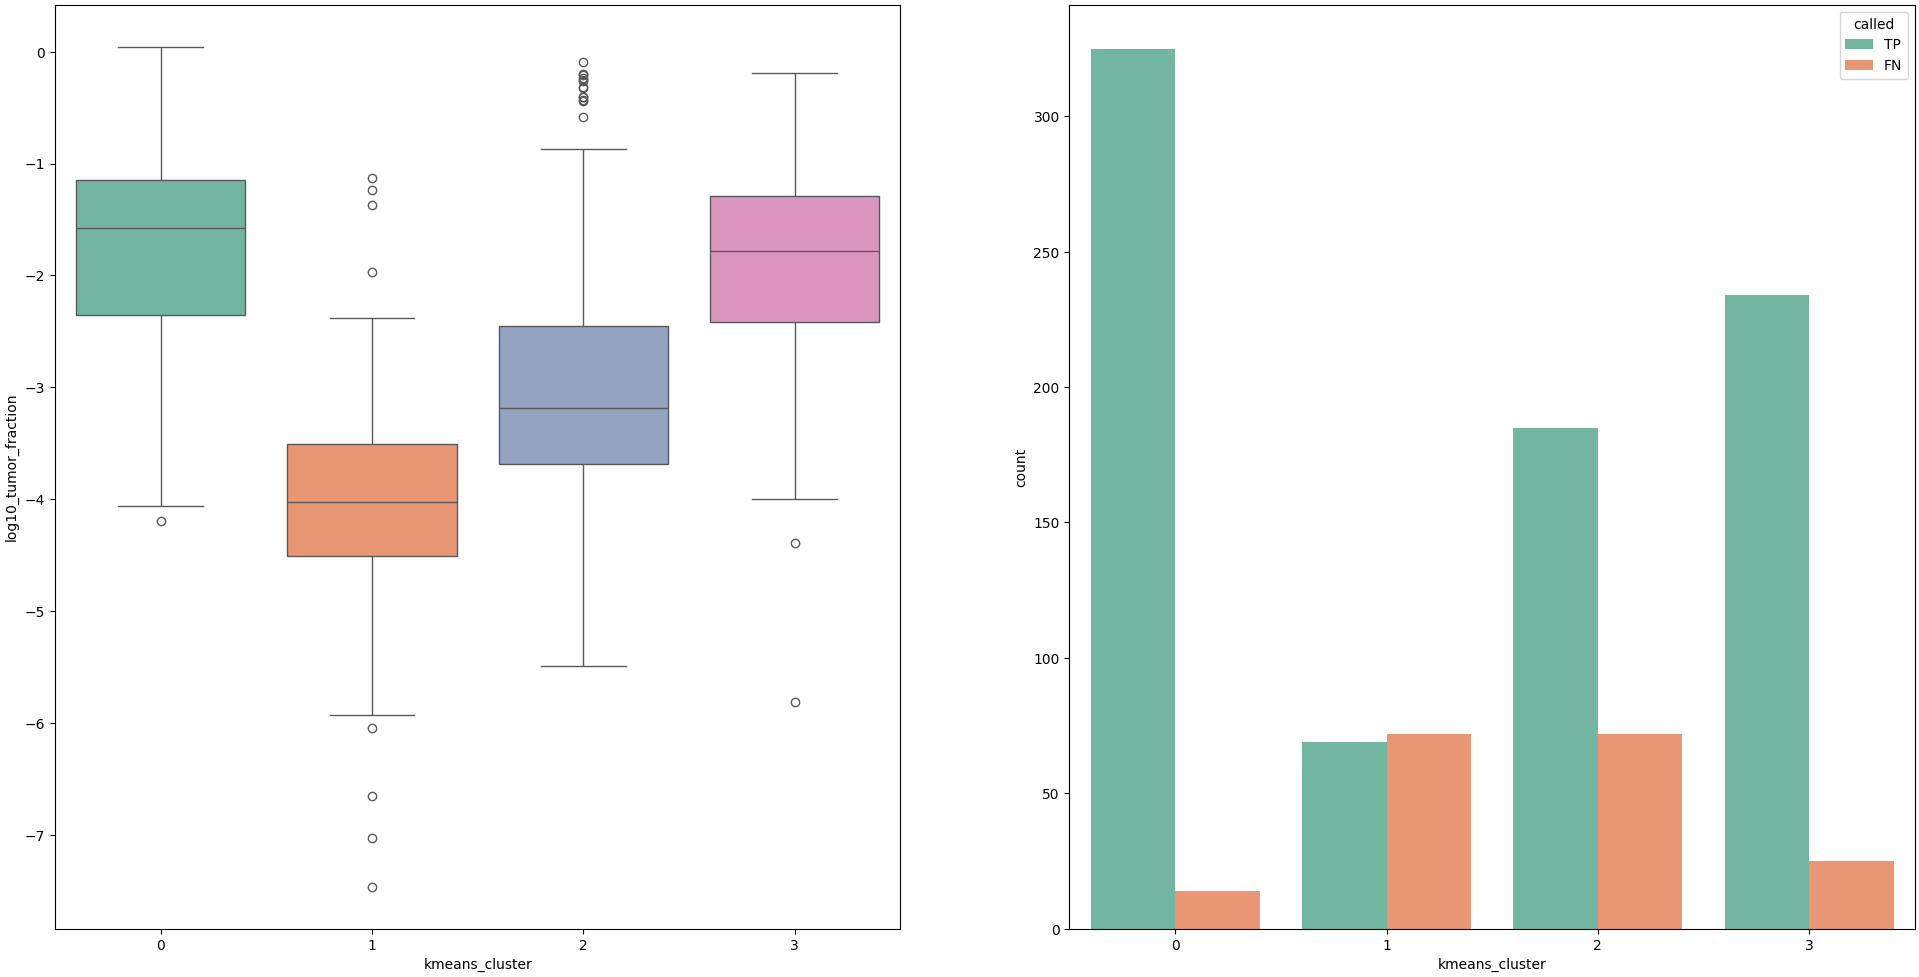

In [28]:
## Meta-info distribution across clusters

fig, axes = plt.subplots(1,2,figsize=(24,12))

with plt.style.context('_classic_test_patch'):

    sns.boxplot(data = df,
                x = 'kmeans_cluster',
                y = 'log10_tumor_fraction',
                ax = axes[0],
                palette = 'Set2')

    sns.countplot(data = df,
                  x = 'kmeans_cluster',
                  hue = 'called',
                  ax = axes[1],
                  palette = 'Set2')




In [29]:
## convert cluster label to string
X_lung_z['kmeans_cluster'] = X_lung_z['kmeans_cluster'].astype("str")
X_lung_z['dbscan_cluster'] = X_lung_z['dbscan_cluster'].astype("str")

## expression data
df_exprs = df_lung_double_z_roi.T
df_exprs[df_exprs > 5] = 5

## column annotation
df_anno = pd.merge(df_lung_meta, X_lung_z, left_index=True, right_index=True)

## row annotation
region_anno.head()

sens_threshold    lod          maf_arg sample_group_cancer  \
region_id                                                                 
merged_1063              50  0.933  tvf_max_maf_pct                lung   
merged_1084              50  0.879  tvf_max_maf_pct                lung   
merged_1114              50  0.953  tvf_max_maf_pct                lung   
merged_1120              50  0.696  tvf_max_maf_pct                lung   
merged_1145              50  0.957  tvf_max_maf_pct                lung   

              log_lod sample_group   snr_p15   snr_p30   snr_p50   snr_p80  \
region_id                                                                    
merged_1063 -0.069350         lung  0.021951  0.088778  0.144192  0.203556   
merged_1084 -0.128970         lung  1.566865  1.790218  2.024377  2.172759   
merged_1114 -0.048140         lung  1.298919  1.611533  1.798833  1.902381   
merged_1120 -0.362406         lung  2.456439  2.873650  3.254021  3.236376   
merged_1145 -0.043952         lung  1.679814  2.347190  2.919942  3.302863   

              snr_p90   snr_p98  snr_p100 in_v6 no_molecule  \
region_id                                                     
merged_1063  0.220116  0.232560  0.235573   yes          no   
merged_1084  2.208378  2.214453  2.234390   yes          no   
merged_1114  1.930828  1.951325  1.969295   yes          no   
merged_1120  3.221483  3.185637  3.199183   yes          no   
merged_1145  3.244055  3.181707  3.217006   yes          no   

             region_score_median  standard_median  double_z_median  \
region_id                                                            
merged_1063            -5.000000        -0.102909         0.011259   
merged_1084            -4.455528        -0.288598         0.001649   
merged_1114            -4.429724        -0.276919         0.007534   
merged_1120            -4.236945        -0.177630         0.126809   
merged_1145            -5.000000        -0.683559        -0.644936   

             pos_control  
region_id                 
merged_1063          0.0  
merged_1084          0.0  
merged_1114          0.0  
merged_1120          0.0  
merged_1145          0.0

Starting plotting HeatmapAnnotations


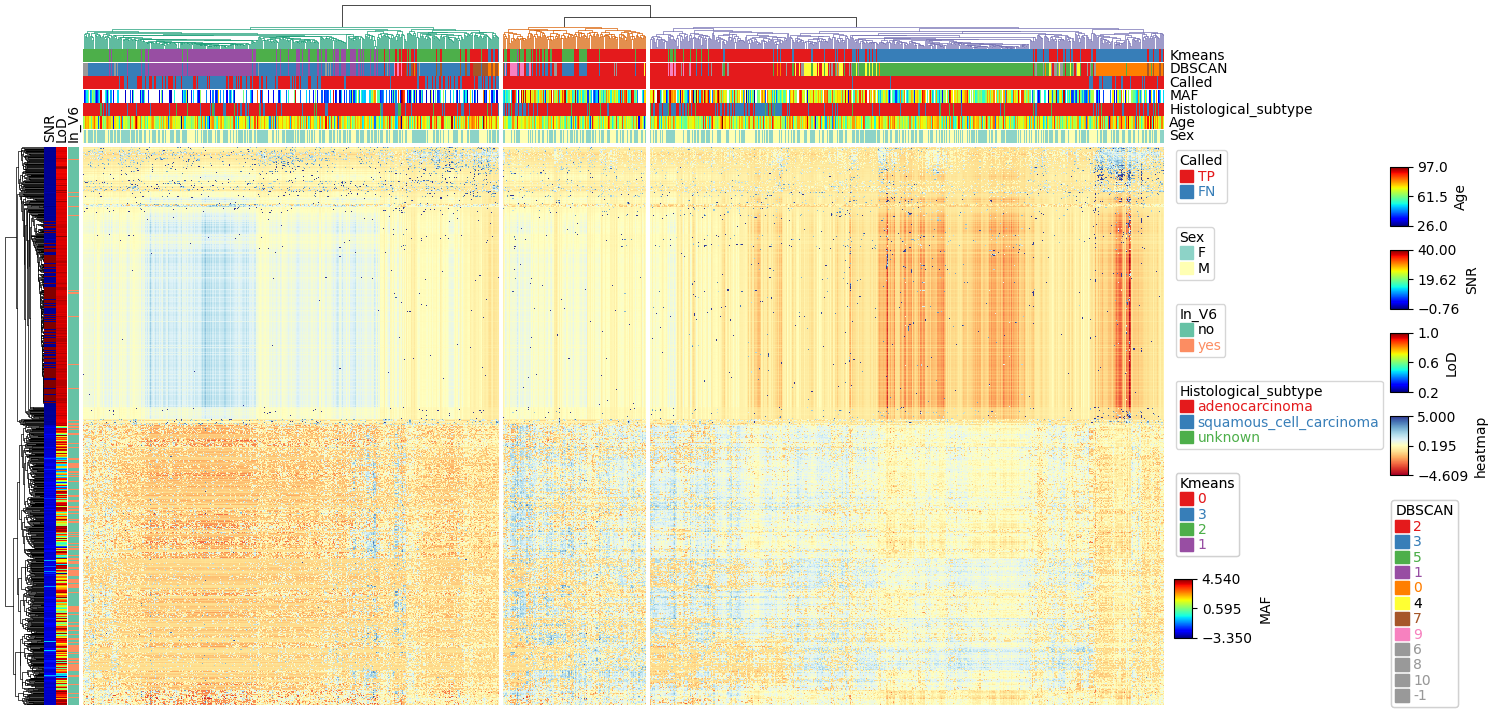

In [30]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
col_annot = pyc.HeatmapAnnotation(Kmeans=pyc.anno_simple(df_anno.kmeans_cluster, cmap='Set1'),
                                  DBSCAN=pyc.anno_simple(df_anno.dbscan_cluster,cmap='Set1'),
                                  Called=pyc.anno_simple(df_anno.called, cmap='Set1'),
                                  MAF=pyc.anno_simple(df_anno.log_tvf_maf),
                                  Histological_subtype=pyc.anno_simple(df_anno.histological_subtype),
                                  Age=pyc.anno_simple(df_anno.age),
                                  Sex=pyc.anno_simple(df_anno.sex, cmap='Set3'),axis=1, 
                                  verbose=False)

# make annotations for regions/rows
#region_annot = pd.DataFrame(index=cgp_sandbox_cancer_type.index.values)
#region_annot['region_type'] = ['v6' if 'merged' in x else 's3' for x in region_annot.index]
row_annot = pyc.HeatmapAnnotation(SNR=pyc.anno_simple(region_anno.snr_p100),
                                  LoD=pyc.anno_simple(region_anno.lod),
                                  In_V6=pyc.anno_simple(region_anno.in_v6, cmap='Set2'),axis=0)

cm = pyc.ClusterMapPlotter(data=df_exprs, 
                           top_annotation=col_annot, 
                           left_annotation=row_annot,
                           cmap='RdYlBu', 
                           col_dendrogram=True,  
                           row_dendrogram=True,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=3, 
                           col_split_gap=1, 
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()

## Load cancer-free samples and compaire

In [31]:
with open('/screening/notebooks/zhuang/summer_2024/data/cf_region_and_kmeans' , 'rb') as f:
    cf_region_and_kmeans = pickle.load(f)
print(cf_region_and_kmeans.shape)

(995, 19136)


In [38]:
c3 = cf_region_and_kmeans.query('kmeans_cluster == "3" ').\
    drop(["kmeans_cluster", "sample_group"],axis=1)

c1 = cf_region_and_kmeans.query('kmeans_cluster == "1" ').\
    drop(["kmeans_cluster", "sample_group"],axis=1)

In [45]:
intersection_region = list(set(c3.columns).intersection(set(df_lung_region.columns)))

In [46]:
df_lung_region = df_lung_region.loc[:,intersection_region]

In [51]:
df = pd.concat([df_lung_region, c1],axis=0)

In [52]:
sample_corr_c1 = df.T.corr()

In [53]:
sample_corr_c1_triu = sample_corr_c1.values[np.triu_indices_from(sample_corr_c1, k=1)]

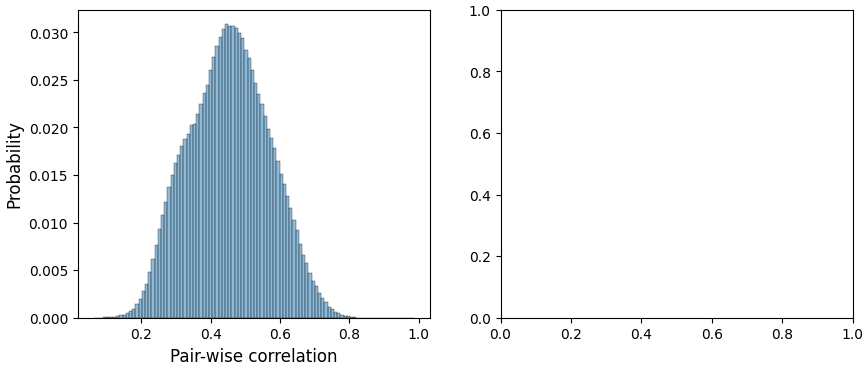

In [54]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
    
with plt.style.context('_classic_test_patch'):
    
    sns.histplot(sample_corr_c1_triu,
                 bins = 100,
                 kde = False,
                 alpha = 0.5,
                 stat = 'probability',
                 ax = axes[0])
    
    axes[0].set_xlabel('Pair-wise correlation', fontsize=12)
    axes[0].set_ylabel('Probability', fontsize=12)
    #axes[0].set_title(key + ' (All Regions)', fontsize=12)